# Stock purchase recommendations with Machine Learning - Data Preparation

## 1) Data Preparation
The purpose of this notebook is to build the routines to load the data and to build features. The output is a completed data structure (saved off in ../data/interim folder_ that is ready for the machine learning workbook(s)

In [3]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook # progress bar
import fastparquet
import pickle
from sklearn.model_selection import train_test_split

In [4]:
pd.set_option('display.max_columns', 1500)

In [5]:
# read in the Quandl.com API key - saved in separate file to keep it private

filepath = '../confidential-API-key.txt'  
with open(filepath) as fp:  
   my_Quandl_API_key = fp.readline()

## Load stock data from Quandl

In [6]:
def load_stock_data(ticker, start_date, end_date, Quandl_API_key=my_Quandl_API_key):
    '''
    Downloads stock data from Quandl, drop some columns, resort datafram, and return
    Inputs:
        ticker - a stock ticker symbol (needs to be valid - no error checking implemented)
        start_date - first date of stock prices
        end_date - last date of stock prices
        Quandl_API_key - string with valid API key for Quandl.com data queries
    Outputs:
        stock_data - DataFrame with stock price data, sorted in ascending date order
    '''
    
    # download data from Quandl with Pandas Datareader
    stock_data = web.DataReader(name=ticker, data_source='quandl', start=start_date, end=end_date, access_key=Quandl_API_key)
    
    # need ascending index for the TA-lib indicators to work properly
    stock_data.sort_index(inplace=True)
    
    # keep only the columns with adjusted data to eliminate any issues due to stock splits
    stock_data = stock_data[['AdjVolume', 'AdjOpen', 'AdjHigh', 'AdjLow', 'AdjClose']]
    
    # DataFrame has a second level column index with the stock ticker - not needed so drop it
    # stock_data.columns = stock_data.columns.droplevel(1) # not needed for panda_datareader v 0.6.0. needed for v 0.7.0
    
    # add row index (highest number is most recent date) - this will be used to later restack the rows for feature matrix
    stock_data['row_index'] = range(0, stock_data.shape[0])
    
    return stock_data    

In [7]:
# test loading stock data:

start = '2013-01-01'
end = '2019-04-06'
symbol = 'AAPL.US'

df = load_stock_data(symbol, start, end)

df.head()

,AdjVolume,AdjOpen,AdjHigh,AdjLow,AdjClose,row_index
Date,,,,,,
2013-01-02,140129500.0,71.816894,71.969911,70.236149,71.195748,0
2013-01-03,88241300.0,71.046621,71.278740,70.154453,70.296565,1
2013-01-04,148583400.0,69.631213,69.847109,68.187094,68.338996,2
2013-01-07,121039100.0,67.690619,68.637250,66.808825,67.937002,3
2013-01-08,114676800.0,68.625579,68.973109,67.593362,68.119845,4


In [8]:
df.shape

(1316, 6)

In [9]:
df.tail()

,AdjVolume,AdjOpen,AdjHigh,AdjLow,AdjClose,row_index
Date,,,,,,
2018-03-21,35247358.0,175.04,175.09,171.26,171.270,1311
2018-03-22,41051076.0,170.00,172.68,168.60,168.845,1312
2018-03-23,40248954.0,168.39,169.92,164.94,164.940,1313
2018-03-26,36272617.0,168.07,173.10,166.44,172.770,1314
2018-03-27,38962839.0,173.68,175.15,166.92,168.340,1315


## Define Target column: profitability of trade

The goal is the define a column "setup_for_profitable_trade" based on a trading strategy. The data will be analyzed for this trade setup:

Run the analysis in the evening after market close. That day's row of market data will then be either deemed as profitable or not for a trade to be initiated and closed in the following days. This setup of the data ensures no lookahead is happening.

## Trading Strategy:

1. After market close on day N decide if buying stock at market Open on day N+1
2. Open position: submit market order for day N+1 prior to market open
3. Close position: submit sell order for market open for day N+10

Threshold to decide to buy the stock: expected profit from open to close: 2.5% profit

Store in row N if this trade was deemed profitable.

In [10]:
def add_flag_for_profitable_trade_setups(df, delete_interim_calculation_cols=True):
    '''
    Adds column to dataframe that identifies profitable trading setup
    Inputs:
        df - dataframe with stock data
        delete_interim_calculation_cols - if false: keep the interim calculations - good for debugging
    Outputs:
        df - dataframe with additional columns
    
    '''
    
    # trade strategy: after market close on day N, set a buy at market open on day N+1 and sell at market close on day N+1
    # for expected gain of at least 2.5%
    profitability_threshold = 0.025

    # use helper columns to calculate profit
    df['strategy_open_price'] = df['AdjOpen'].shift(-1) # AdjOpen from day N+1
    df['strategy_close_price'] = df['AdjOpen'].shift(-10) # AdjOpen from day N+10
    df['strategy_profit_dollars'] = df['strategy_close_price'] - df['strategy_open_price']
    df['strategy_profitability'] = df['strategy_profit_dollars'] / df['strategy_open_price']

    # use categorical field to encode "setup_for_succesful_trade": 1=yes, 0=no
    df['setup_for_profitable_trade'] = df['strategy_profitability'] >= profitability_threshold
    
    if delete_interim_calculation_cols:
        df = df.drop(columns=['strategy_open_price', 'strategy_close_price', 'strategy_profit_dollars', 'strategy_profitability'])
    
    # drop any rows that have NaNs in them. especially the last few rows will have NaNs because the profitability calc
    # looks into the future beyond the last row. these rows need to get deleted - the profitability is not defined there
    df = df.loc[df.notnull().all(axis=1), :]
    
    return df

In [11]:
# testing: show calculations:
df = add_flag_for_profitable_trade_setups(df, False)
df.tail(10)

,AdjVolume,AdjOpen,AdjHigh,AdjLow,AdjClose,row_index,strategy_open_price,strategy_close_price,strategy_profit_dollars,strategy_profitability,setup_for_profitable_trade
Date,,,,,,,,,,,
2018-02-28,33604574.0,179.26,180.615,178.05,178.12,1296,178.54,180.32,1.78,0.009970,False
2018-03-01,48801970.0,178.54,179.775,172.66,175.00,1297,172.80,178.50,5.70,0.032986,True
2018-03-02,38453950.0,172.80,176.300,172.45,176.21,1298,175.21,178.65,3.44,0.019634,False
2018-03-05,28401366.0,175.21,177.740,174.52,176.82,1299,177.91,177.32,-0.59,-0.003316,False
2018-03-06,23788506.0,177.91,178.250,176.13,176.67,1300,174.94,175.24,0.30,0.001715,False
2018-03-07,31703462.0,174.94,175.850,174.27,175.03,1301,175.48,175.04,-0.44,-0.002507,False
2018-03-08,23163767.0,175.48,177.120,175.07,176.94,1302,177.96,170.00,-7.96,-0.044729,False
2018-03-09,31385134.0,177.96,180.000,177.39,179.98,1303,180.29,168.39,-11.90,-0.066005,False
2018-03-12,32055405.0,180.29,182.390,180.21,181.72,1304,182.59,168.07,-14.52,-0.079522,False


In [12]:
# without verbose results:
df = add_flag_for_profitable_trade_setups(df)
df.tail(10)

,AdjVolume,AdjOpen,AdjHigh,AdjLow,AdjClose,row_index,setup_for_profitable_trade
Date,,,,,,,
2018-02-28,33604574.0,179.26,180.615,178.05,178.12,1296,False
2018-03-01,48801970.0,178.54,179.775,172.66,175.00,1297,False
2018-03-02,38453950.0,172.80,176.300,172.45,176.21,1298,False
2018-03-05,28401366.0,175.21,177.740,174.52,176.82,1299,False
2018-03-06,23788506.0,177.91,178.250,176.13,176.67,1300,False
2018-03-07,31703462.0,174.94,175.850,174.27,175.03,1301,False
2018-03-08,23163767.0,175.48,177.120,175.07,176.94,1302,False
2018-03-09,31385134.0,177.96,180.000,177.39,179.98,1303,False
2018-03-12,32055405.0,180.29,182.390,180.21,181.72,1304,False


In [13]:
# how many profitable trades were there in this dataset?
df['setup_for_profitable_trade'].sum()

447

In [14]:
df.shape[0]

1306

In [15]:
# percentage of days with profitable trade setup:
df['setup_for_profitable_trade'].sum() / df.shape[0]

0.34226646248085757

## 2) Feature Engineering

In [16]:
#split df into features and target (column setup_for_profitable_trade)
df_X_base_data = df.drop(columns=['setup_for_profitable_trade'])

### Feature Engineering - Add Technical Analysis Indicators
To enhance the ability to forecast stock prices/profitable trades, we will enrich the stock price data set with technical indicators as addtitional features

We will utilize the TA-Lib library to calculate technichal indicators and add their values as additional columns

In [17]:
def add_TALib_indicator(df, attribute, indicator_func, *args):
    '''
    Adds a column to a dataframe:
        column name is the name of the technical indicator as specified by indicator_func
        column content is the function calculated on the attribute column
    Example: add_TALib_indicator(df, 'AdjClose', ta.RSI, 14) creates a new column called RSI with 
             the 14 day RSI of the values of the column 'AdjClose'
    Inputs:
        df - dataframe - needs to be sorted in date ascending order
        attribute - column name to be used in TA-Lib calculation
        indicator_func - name of a TA-Lib function
        *args - optional parameters for indicator_func
        
    Oupputs:
        df - datarame with new column added
        func_name - name of the new colunm
    
    '''
    # get the name of the indicator from TA-Lib
    func_name = attribute + indicator_func.__name__ + str(*args)
    
    # add new column, calculated based on attribute column
    df.loc[:, func_name] = indicator_func(df.loc[:, attribute].values, *args)
    
    return df, func_name

Additionally, we will add comparisons between the indicator value and a base column. Using this function we can calculate the crossover of the base data over a moving average or other momentum indicator

In [18]:
def add_comparison_cols_for_indicator(df, base_col_name, indicator_col_name, delete_indicator_col=True):
    '''
    adds columns that compare indicator_col to base_col: ratio, crossover, above/below
    Inputs:
        df - dataframe
        base_col_name - name of column that the indicator will get compared to
        indicator_col_name - name of column that has indicator values
        delete_base_col - yes/no on if to keep the base col or not
    Output:
        df - modified df with added & removed columns
    '''
   
    # indicator to base column ratio:
    df.loc[:, indicator_col_name + '_to_' + base_col_name + '_ratio'] = df.loc[:, indicator_col_name] / df.loc[:, base_col_name]
    
    # base col above indicator:
    base_above_indicator_col_name = base_col_name + '_above_' + indicator_col_name
    df.loc[:, base_above_indicator_col_name] = df.loc[:, indicator_col_name] < df.loc[:, base_col_name]
    
    # did base cross indicator
    base_crossed_indicator_col_name = base_col_name + '_crossed_' + indicator_col_name
    df.loc[:, base_crossed_indicator_col_name] = df.loc[:, base_above_indicator_col_name] != df.loc[:, base_above_indicator_col_name].shift(1)
    
    if delete_indicator_col:
        df = df.drop(columns=indicator_col_name)
    
    return df

In [19]:
# add a few indicators:

# RSI - Relative Strenght Index
df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.RSI, 14)
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

# SMA - Simple Moving Average - 10 day window
df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 10)
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

# SMA - Simple Moving Average - 50 day window
df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 50)
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

# SMA - Simple Moving Average - 200 day window
df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 200)
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

# more complex combinations:

# Crossover between 50 day SMA and 200 day SMA
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjCloseSMA200', 'AdjCloseSMA50', delete_indicator_col=False)

# Crossover between 50 day SMA and 200 day SMA
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjCloseSMA50', 'AdjCloseSMA10', delete_indicator_col=False)


df_X_base_data.tail(20).T

Date,2018-02-13 00:00:00,2018-02-14 00:00:00,2018-02-15 00:00:00,2018-02-16 00:00:00,2018-02-20 00:00:00,2018-02-21 00:00:00,2018-02-22 00:00:00,2018-02-23 00:00:00,2018-02-26 00:00:00,2018-02-27 00:00:00,2018-02-28 00:00:00,2018-03-01 00:00:00,2018-03-02 00:00:00,2018-03-05 00:00:00,2018-03-06 00:00:00,2018-03-07 00:00:00,2018-03-08 00:00:00,2018-03-09 00:00:00,2018-03-12 00:00:00,2018-03-13 00:00:00
AdjVolume,3.21048e+07,3.96692e+07,5.06096e+07,3.96388e+07,3.3531e+07,3.58335e+07,3.05041e+07,3.33292e+07,3.68864e+07,3.86852e+07,3.36046e+07,4.8802e+07,3.8454e+07,2.84014e+07,2.37885e+07,3.17035e+07,2.31638e+07,3.13851e+07,3.20554e+07,3.11684e+07
AdjOpen,161.95,163.045,169.79,172.36,172.05,172.83,171.8,173.67,176.35,179.1,179.26,178.54,172.8,175.21,177.91,174.94,175.48,177.96,180.29,182.59
AdjHigh,164.75,167.54,173.09,174.82,174.26,174.12,173.95,175.65,179.39,180.48,180.615,179.775,176.3,177.74,178.25,175.85,177.12,180,182.39,183.5
AdjLow,161.65,162.88,169,171.77,171.42,171.01,171.71,173.54,176.21,178.16,178.05,172.66,172.45,174.52,176.13,174.27,175.07,177.39,180.21,179.24
AdjClose,164.34,167.37,172.99,172.43,171.85,171.07,172.6,175.555,178.97,178.39,178.12,175,176.21,176.82,176.67,175.03,176.94,179.98,181.72,179.97
row_index,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305
AdjCloseRSI14,45.9965,50.6795,57.9612,57.0572,56.0816,54.7264,56.9252,60.8772,64.8867,63.6928,63.1106,56.6654,58.4381,59.3412,59.0017,55.2782,58.5584,63.1865,65.5574,61.2825
AdjCloseRSI14_to_AdjClose_ratio,0.279886,0.302799,0.335055,0.330901,0.326341,0.319907,0.32981,0.34677,0.362556,0.357042,0.354315,0.323802,0.331639,0.335602,0.333965,0.315821,0.33095,0.351075,0.360761,0.340515
AdjClose_above_AdjCloseRSI14,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
AdjClose_crossed_AdjCloseRSI14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [20]:
df_X_base_data.head(16)
#confirms NaN for RSI on top for first 14 dates since it is a 14 day RSI

,AdjVolume,AdjOpen,AdjHigh,AdjLow,AdjClose,row_index,AdjCloseRSI14,AdjCloseRSI14_to_AdjClose_ratio,AdjClose_above_AdjCloseRSI14,AdjClose_crossed_AdjCloseRSI14,AdjCloseSMA10,AdjCloseSMA10_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA10,AdjClose_crossed_AdjCloseSMA10,AdjCloseSMA50,AdjCloseSMA50_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA50,AdjClose_crossed_AdjCloseSMA50,AdjCloseSMA200,AdjCloseSMA200_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA200,AdjClose_crossed_AdjCloseSMA200,AdjCloseSMA50_to_AdjCloseSMA200_ratio,AdjCloseSMA200_above_AdjCloseSMA50,AdjCloseSMA200_crossed_AdjCloseSMA50,AdjCloseSMA10_to_AdjCloseSMA50_ratio,AdjCloseSMA50_above_AdjCloseSMA10,AdjCloseSMA50_crossed_AdjCloseSMA10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,140129500.0,71.816894,71.969911,70.236149,71.195748,0,NaN,NaN,False,True,NaN,NaN,False,True,NaN,NaN,False,True,NaN,NaN,False,True,NaN,False,True,NaN,False,True
2013-01-03,88241300.0,71.046621,71.278740,70.154453,70.296565,1,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,False,False,NaN,False,False
2013-01-04,148583400.0,69.631213,69.847109,68.187094,68.338996,2,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,False,False,NaN,False,False
2013-01-07,121039100.0,67.690619,68.637250,66.808825,67.937002,3,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,False,False,NaN,False,False
2013-01-08,114676800.0,68.625579,68.973109,67.593362,68.119845,4,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,False,False,NaN,False,False
2013-01-09,101901100.0,67.755456,68.080345,66.911269,67.055209,5,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,False,False,NaN,False,False
2013-01-10,150286500.0,68.539993,68.562038,66.850321,67.886429,6,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,False,False,NaN,False,False
2013-01-11,87626700.0,67.560943,68.121141,67.304186,67.470170,7,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,False,False,NaN,False,False
2013-01-14,183551900.0,65.185288,65.810324,64.644541,65.064689,8,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,NaN,False,False,NaN,False,False,NaN,False,False


### Feature Engineering - Changing from actual values to percentage changes
For many columns the absolute value is not as important as the change from one day (row) to the next (row). For example, the absolute price of the stock is not important but the percentage gain or loss is

In [21]:
def feat_eng_changes_values_to_change(df, cols_set_vals_to_change, delete_original_cols=True):
    '''
    Instead of the actual values in some columns, we care about the change from one day to the next.
    This function calculates that change for the given columns and then either keeps or drops (default) the origianl columns
    Input:
        df - a dataframe
        cols_set_vals_to_change - names of columns to work on.
        delete_original_cols - keep or delete original columns
    Output:
        df - dataframe with new columns added. the value in row N is now the change from row N-1 to row N (instead of the actual values)
    '''    

    # calculate the change from row N-1 to row N
    df_chg_cols = (df[cols_set_vals_to_change] / df[cols_set_vals_to_change].shift(1) - 1)

    # add suffix to the column names
    df_chg_cols = df_chg_cols.add_suffix('_chg')

    # join the data onto the original data fram
    df = df.join(df_chg_cols)

    if delete_original_cols:
        # drop the original columns
        df = df.drop(columns=cols_set_vals_to_change)
        
    return df

cols_set_vals_to_change = ['AdjVolume', 'AdjOpen', 'AdjLow', 'AdjHigh', 'AdjClose', 'AdjCloseSMA10', 'AdjCloseSMA50', 'AdjCloseSMA200']
df_X_base_data = feat_eng_changes_values_to_change(df_X_base_data, cols_set_vals_to_change, delete_original_cols=False)

df_X_base_data.tail().T

Date,2018-03-07 00:00:00,2018-03-08 00:00:00,2018-03-09 00:00:00,2018-03-12 00:00:00,2018-03-13 00:00:00
AdjVolume,3.17035e+07,2.31638e+07,3.13851e+07,3.20554e+07,3.11684e+07
AdjOpen,174.94,175.48,177.96,180.29,182.59
AdjHigh,175.85,177.12,180,182.39,183.5
AdjLow,174.27,175.07,177.39,180.21,179.24
AdjClose,175.03,176.94,179.98,181.72,179.97
row_index,1301,1302,1303,1304,1305
AdjCloseRSI14,55.2782,58.5584,63.1865,65.5574,61.2825
AdjCloseRSI14_to_AdjClose_ratio,0.315821,0.33095,0.351075,0.360761,0.340515
AdjClose_above_AdjCloseRSI14,True,True,True,True,True
AdjClose_crossed_AdjCloseRSI14,False,False,False,False,False


We now have the data for one stock in our dataframe df_X_base_data. Save it for future processing:

In [22]:
fastparquet.write('../data/interim/df_X_base_data.parq', df_X_base_data)

### Feature Engineering - Reshaping the prior day data into ML-ready features matrix
#### --- build pieces for the dataframe section unpivoting ---
Goal: pull out n_features rows, flatten, and build meaningful column names that indicate how many days' back the data is from. Building this function in pieces here:

In [23]:
#load the data back:
df_X_base_data = fastparquet.ParquetFile('../data/interim/df_X_base_data.parq').to_pandas()

In [24]:
# parameter for how many days of history to include in feature list
n_days_features = 5

# total lenght of df
n_data_points = df.shape[0]

In [25]:
i = 505
# pull out n_days_features of rows from current position
df_extract = df_X_base_data.iloc[i-n_days_features:i, :].copy()

# change the index the be "days into the past" - eg current day is 0, prior day is -1, ...
df_extract.loc[:, 'row_index'] = range(-n_days_features+1, 1)

# make this the new index
df_extract.set_index('row_index', inplace=True)

df_extract

,AdjVolume,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjCloseRSI14,AdjCloseRSI14_to_AdjClose_ratio,AdjClose_above_AdjCloseRSI14,AdjClose_crossed_AdjCloseRSI14,AdjCloseSMA10,AdjCloseSMA10_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA10,AdjClose_crossed_AdjCloseSMA10,AdjCloseSMA50,AdjCloseSMA50_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA50,AdjClose_crossed_AdjCloseSMA50,AdjCloseSMA200,AdjCloseSMA200_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA200,AdjClose_crossed_AdjCloseSMA200,AdjCloseSMA50_to_AdjCloseSMA200_ratio,AdjCloseSMA200_above_AdjCloseSMA50,AdjCloseSMA200_crossed_AdjCloseSMA50,AdjCloseSMA10_to_AdjCloseSMA50_ratio,AdjCloseSMA50_above_AdjCloseSMA10,AdjCloseSMA50_crossed_AdjCloseSMA10,AdjVolume_chg,AdjOpen_chg,AdjLow_chg,AdjHigh_chg,AdjClose_chg,AdjCloseSMA10_chg,AdjCloseSMA50_chg,AdjCloseSMA200_chg
row_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-4,33720951.0,106.495469,108.794479,106.409968,108.290977,55.633496,0.513741,True,False,105.452364,0.973787,True,False,104.980304,0.969428,True,False,90.551157,0.836184,True,False,1.159348,False,False,1.004497,False,False,1.328858,-0.004264,0.000000,0.016059,0.017677,0.002140,0.003063,0.002066
-3,27598920.0,108.100976,109.031980,108.015476,108.214976,55.382828,0.511785,True,False,105.849466,0.978141,True,False,105.323529,0.973281,True,False,90.741442,0.838529,True,False,1.160699,False,False,1.004994,False,False,-0.181550,0.015076,0.015088,0.002183,-0.000702,0.003766,0.003269,0.002101
-2,29881477.0,107.958475,108.224476,106.504969,106.894471,51.076636,0.477823,True,False,106.257493,0.994041,True,False,105.613670,0.988018,True,False,90.923753,0.850594,True,False,1.161563,False,False,1.006096,False,False,0.082705,-0.001318,-0.013984,-0.007406,-0.012203,0.003855,0.002755,0.002009
-1,41403351.0,107.179472,107.473973,104.699961,104.861462,45.244023,0.431465,True,False,106.602819,1.016606,False,True,105.823611,1.009175,False,True,91.092783,0.868696,True,False,1.161712,False,False,1.007363,False,False,0.385586,-0.007216,-0.016948,-0.006935,-0.019019,0.003250,0.001988,0.001859
0,53204626.0,105.820966,105.868466,101.982949,103.863957,42.669377,0.410820,True,False,106.595219,1.026297,False,False,105.962334,1.020203,False,False,91.256920,0.878620,True,False,1.161143,False,False,1.005973,False,False,0.285032,-0.012675,-0.025950,-0.014939,-0.009513,-0.000071,0.001311,0.001802


In [26]:
# normalize columns from dollars to "1" - turns the columns into ratios compared to day N (index 0)

cols_to_normalize_to_1_for_day_0 = ['AdjVolume', 'AdjOpen', 'AdjLow', 'AdjHigh', 'AdjClose', 'AdjCloseSMA10', 'AdjCloseSMA50', 'AdjCloseSMA200']

df_extract.loc[:, cols_to_normalize_to_1_for_day_0] = df_extract.loc[:, cols_to_normalize_to_1_for_day_0] / df_extract.loc[0, cols_to_normalize_to_1_for_day_0]

df_extract

,AdjVolume,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjCloseRSI14,AdjCloseRSI14_to_AdjClose_ratio,AdjClose_above_AdjCloseRSI14,AdjClose_crossed_AdjCloseRSI14,AdjCloseSMA10,AdjCloseSMA10_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA10,AdjClose_crossed_AdjCloseSMA10,AdjCloseSMA50,AdjCloseSMA50_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA50,AdjClose_crossed_AdjCloseSMA50,AdjCloseSMA200,AdjCloseSMA200_to_AdjClose_ratio,AdjClose_above_AdjCloseSMA200,AdjClose_crossed_AdjCloseSMA200,AdjCloseSMA50_to_AdjCloseSMA200_ratio,AdjCloseSMA200_above_AdjCloseSMA50,AdjCloseSMA200_crossed_AdjCloseSMA50,AdjCloseSMA10_to_AdjCloseSMA50_ratio,AdjCloseSMA50_above_AdjCloseSMA10,AdjCloseSMA50_crossed_AdjCloseSMA10,AdjVolume_chg,AdjOpen_chg,AdjLow_chg,AdjHigh_chg,AdjClose_chg,AdjCloseSMA10_chg,AdjCloseSMA50_chg,AdjCloseSMA200_chg
row_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-4,0.633797,1.00637,1.02764,1.04341,1.04262,55.633496,0.513741,True,False,0.989279,0.973787,True,False,0.990732,0.969428,True,False,0.992266,0.836184,True,False,1.159348,False,False,1.004497,False,False,1.328858,-0.004264,0.000000,0.016059,0.017677,0.002140,0.003063,0.002066
-3,0.518732,1.02155,1.02988,1.05915,1.04189,55.382828,0.511785,True,False,0.993004,0.978141,True,False,0.993971,0.973281,True,False,0.994351,0.838529,True,False,1.160699,False,False,1.004994,False,False,-0.181550,0.015076,0.015088,0.002183,-0.000702,0.003766,0.003269,0.002101
-2,0.561633,1.0202,1.02225,1.04434,1.02918,51.076636,0.477823,True,False,0.996832,0.994041,True,False,0.99671,0.988018,True,False,0.996349,0.850594,True,False,1.161563,False,False,1.006096,False,False,0.082705,-0.001318,-0.013984,-0.007406,-0.012203,0.003855,0.002755,0.002009
-1,0.778191,1.01284,1.01517,1.02664,1.0096,45.244023,0.431465,True,False,1.00007,1.016606,False,True,0.998691,1.009175,False,True,0.998201,0.868696,True,False,1.161712,False,False,1.007363,False,False,0.385586,-0.007216,-0.016948,-0.006935,-0.019019,0.003250,0.001988,0.001859
0,1,1,1,1,1,42.669377,0.410820,True,False,1,1.026297,False,False,1,1.020203,False,False,1,0.878620,True,False,1.161143,False,False,1.005973,False,False,0.285032,-0.012675,-0.025950,-0.014939,-0.009513,-0.000071,0.001311,0.001802


In [27]:
# unstack and make it tall (ie unpivot)
df_extract = df_extract.unstack().reset_index()
df_extract

,level_0,row_index,0
0,AdjVolume,-4,0.633797
1,AdjVolume,-3,0.518732
2,AdjVolume,-2,0.561633
3,AdjVolume,-1,0.778191
4,AdjVolume,0,1
5,AdjOpen,-4,1.00637
6,AdjOpen,-3,1.02155
7,AdjOpen,-2,1.0202
8,AdjOpen,-1,1.01284
9,AdjOpen,0,1


In [28]:
# create new column with combined field names of attribute and index
# eg: AdjClose-1 for the adjusted close of day N-1 or AdjHigh-4 for the adjusted High of day N-4
df_extract['Attribute-index'] = df_extract['level_0'] + df_extract['row_index'].apply(str)
# then drop Attributes and row_index columns since they are not needed anymore
df_extract.drop(columns=['level_0', 'row_index'], inplace=True)
df_extract

,0,Attribute-index
0,0.633797,AdjVolume-4
1,0.518732,AdjVolume-3
2,0.561633,AdjVolume-2
3,0.778191,AdjVolume-1
4,1,AdjVolume0
5,1.00637,AdjOpen-4
6,1.02155,AdjOpen-3
7,1.0202,AdjOpen-2
8,1.01284,AdjOpen-1
9,1,AdjOpen0


In [29]:
# set index one and transpose
target_row = df_extract.set_index('Attribute-index').T
# we now have one row of data that represents the prior n_feature_days worth of data:
target_row

Attribute-index,AdjVolume-4,AdjVolume-3,AdjVolume-2,AdjVolume-1,AdjVolume0,AdjOpen-4,AdjOpen-3,AdjOpen-2,AdjOpen-1,AdjOpen0,AdjHigh-4,AdjHigh-3,AdjHigh-2,AdjHigh-1,AdjHigh0,AdjLow-4,AdjLow-3,AdjLow-2,AdjLow-1,AdjLow0,AdjClose-4,AdjClose-3,AdjClose-2,AdjClose-1,AdjClose0,AdjCloseRSI14-4,AdjCloseRSI14-3,AdjCloseRSI14-2,AdjCloseRSI14-1,AdjCloseRSI140,AdjCloseRSI14_to_AdjClose_ratio-4,AdjCloseRSI14_to_AdjClose_ratio-3,AdjCloseRSI14_to_AdjClose_ratio-2,AdjCloseRSI14_to_AdjClose_ratio-1,AdjCloseRSI14_to_AdjClose_ratio0,AdjClose_above_AdjCloseRSI14-4,AdjClose_above_AdjCloseRSI14-3,AdjClose_above_AdjCloseRSI14-2,AdjClose_above_AdjCloseRSI14-1,AdjClose_above_AdjCloseRSI140,AdjClose_crossed_AdjCloseRSI14-4,AdjClose_crossed_AdjCloseRSI14-3,AdjClose_crossed_AdjCloseRSI14-2,AdjClose_crossed_AdjCloseRSI14-1,AdjClose_crossed_AdjCloseRSI140,AdjCloseSMA10-4,AdjCloseSMA10-3,AdjCloseSMA10-2,AdjCloseSMA10-1,AdjCloseSMA100,AdjCloseSMA10_to_AdjClose_ratio-4,AdjCloseSMA10_to_AdjClose_ratio-3,AdjCloseSMA10_to_AdjClose_ratio-2,AdjCloseSMA10_to_AdjClose_ratio-1,AdjCloseSMA10_to_AdjClose_ratio0,AdjClose_above_AdjCloseSMA10-4,AdjClose_above_AdjCloseSMA10-3,AdjClose_above_AdjCloseSMA10-2,AdjClose_above_AdjCloseSMA10-1,AdjClose_above_AdjCloseSMA100,AdjClose_crossed_AdjCloseSMA10-4,AdjClose_crossed_AdjCloseSMA10-3,AdjClose_crossed_AdjCloseSMA10-2,AdjClose_crossed_AdjCloseSMA10-1,AdjClose_crossed_AdjCloseSMA100,AdjCloseSMA50-4,AdjCloseSMA50-3,AdjCloseSMA50-2,AdjCloseSMA50-1,AdjCloseSMA500,AdjCloseSMA50_to_AdjClose_ratio-4,AdjCloseSMA50_to_AdjClose_ratio-3,AdjCloseSMA50_to_AdjClose_ratio-2,AdjCloseSMA50_to_AdjClose_ratio-1,AdjCloseSMA50_to_AdjClose_ratio0,AdjClose_above_AdjCloseSMA50-4,AdjClose_above_AdjCloseSMA50-3,AdjClose_above_AdjCloseSMA50-2,AdjClose_above_AdjCloseSMA50-1,AdjClose_above_AdjCloseSMA500,AdjClose_crossed_AdjCloseSMA50-4,AdjClose_crossed_AdjCloseSMA50-3,AdjClose_crossed_AdjCloseSMA50-2,AdjClose_crossed_AdjCloseSMA50-1,AdjClose_crossed_AdjCloseSMA500,AdjCloseSMA200-4,AdjCloseSMA200-3,AdjCloseSMA200-2,AdjCloseSMA200-1,AdjCloseSMA2000,AdjCloseSMA200_to_AdjClose_ratio-4,AdjCloseSMA200_to_AdjClose_ratio-3,AdjCloseSMA200_to_AdjClose_ratio-2,AdjCloseSMA200_to_AdjClose_ratio-1,AdjCloseSMA200_to_AdjClose_ratio0,AdjClose_above_AdjCloseSMA200-4,AdjClose_above_AdjCloseSMA200-3,AdjClose_above_AdjCloseSMA200-2,AdjClose_above_AdjCloseSMA200-1,AdjClose_above_AdjCloseSMA2000,AdjClose_crossed_AdjCloseSMA200-4,AdjClose_crossed_AdjCloseSMA200-3,AdjClose_crossed_AdjCloseSMA200-2,AdjClose_crossed_AdjCloseSMA200-1,AdjClose_crossed_AdjCloseSMA2000,AdjCloseSMA50_to_AdjCloseSMA200_ratio-4,AdjCloseSMA50_to_AdjCloseSMA200_ratio-3,AdjCloseSMA50_to_AdjCloseSMA200_ratio-2,AdjCloseSMA50_to_AdjCloseSMA200_ratio-1,AdjCloseSMA50_to_AdjCloseSMA200_ratio0,AdjCloseSMA200_above_AdjCloseSMA50-4,AdjCloseSMA200_above_AdjCloseSMA50-3,AdjCloseSMA200_above_AdjCloseSMA50-2,AdjCloseSMA200_above_AdjCloseSMA50-1,AdjCloseSMA200_above_AdjCloseSMA500,AdjCloseSMA200_crossed_AdjCloseSMA50-4,AdjCloseSMA200_crossed_AdjCloseSMA50-3,AdjCloseSMA200_crossed_AdjCloseSMA50-2,AdjCloseSMA200_crossed_AdjCloseSMA50-1,AdjCloseSMA200_crossed_AdjCloseSMA500,AdjCloseSMA10_to_AdjCloseSMA50_ratio-4,AdjCloseSMA10_to_AdjCloseSMA50_ratio-3,AdjCloseSMA10_to_AdjCloseSMA50_ratio-2,AdjCloseSMA10_to_AdjCloseSMA50_ratio-1,AdjCloseSMA10_to_AdjCloseSMA50_ratio0,AdjCloseSMA50_above_AdjCloseSMA10-4,AdjCloseSMA50_above_AdjCloseSMA10-3,AdjCloseSMA50_above_AdjCloseSMA10-2,AdjCloseSMA50_above_AdjCloseSMA10-1,AdjCloseSMA50_above_AdjCloseSMA100,AdjCloseSMA50_crossed_AdjCloseSMA10-4,AdjCloseSMA50_crossed_AdjCloseSMA10-3,AdjCloseSMA50_crossed_AdjCloseSMA10-2,AdjCloseSMA50_crossed_AdjCloseSMA10-1,AdjCloseSMA50_crossed_AdjCloseSMA100,AdjVolume_chg-4,AdjVolume_chg-3,AdjVolume_chg-2,AdjVolume_chg-1,AdjVolume_chg0,AdjOpen_chg-4,AdjOpen_chg-3,AdjOpen_chg-2,AdjOpen_chg-1,AdjOpen_chg0,AdjLow_chg-4,AdjLow_chg-3,AdjLow_chg-2,AdjLow_chg-1,AdjLow_chg0,AdjHigh_chg-4,AdjHigh_chg-3,AdjHigh_chg-2,AdjHigh_chg-1,AdjHigh_chg0,AdjClose_chg-4,AdjClose_c

In [30]:
df_X_base_data.index[504]

Timestamp('2015-01-02 00:00:00')

In [31]:
# get the datestamp back into the index
target_row['Index'] = df_X_base_data.index[504]
target_row = target_row.set_index('Index')
target_row

Attribute-index,AdjVolume-4,AdjVolume-3,AdjVolume-2,AdjVolume-1,AdjVolume0,AdjOpen-4,AdjOpen-3,AdjOpen-2,AdjOpen-1,AdjOpen0,AdjHigh-4,AdjHigh-3,AdjHigh-2,AdjHigh-1,AdjHigh0,AdjLow-4,AdjLow-3,AdjLow-2,AdjLow-1,AdjLow0,AdjClose-4,AdjClose-3,AdjClose-2,AdjClose-1,AdjClose0,AdjCloseRSI14-4,AdjCloseRSI14-3,AdjCloseRSI14-2,AdjCloseRSI14-1,AdjCloseRSI140,AdjCloseRSI14_to_AdjClose_ratio-4,AdjCloseRSI14_to_AdjClose_ratio-3,AdjCloseRSI14_to_AdjClose_ratio-2,AdjCloseRSI14_to_AdjClose_ratio-1,AdjCloseRSI14_to_AdjClose_ratio0,AdjClose_above_AdjCloseRSI14-4,AdjClose_above_AdjCloseRSI14-3,AdjClose_above_AdjCloseRSI14-2,AdjClose_above_AdjCloseRSI14-1,AdjClose_above_AdjCloseRSI140,AdjClose_crossed_AdjCloseRSI14-4,AdjClose_crossed_AdjCloseRSI14-3,AdjClose_crossed_AdjCloseRSI14-2,AdjClose_crossed_AdjCloseRSI14-1,AdjClose_crossed_AdjCloseRSI140,AdjCloseSMA10-4,AdjCloseSMA10-3,AdjCloseSMA10-2,AdjCloseSMA10-1,AdjCloseSMA100,AdjCloseSMA10_to_AdjClose_ratio-4,AdjCloseSMA10_to_AdjClose_ratio-3,AdjCloseSMA10_to_AdjClose_ratio-2,AdjCloseSMA10_to_AdjClose_ratio-1,AdjCloseSMA10_to_AdjClose_ratio0,AdjClose_above_AdjCloseSMA10-4,AdjClose_above_AdjCloseSMA10-3,AdjClose_above_AdjCloseSMA10-2,AdjClose_above_AdjCloseSMA10-1,AdjClose_above_AdjCloseSMA100,AdjClose_crossed_AdjCloseSMA10-4,AdjClose_crossed_AdjCloseSMA10-3,AdjClose_crossed_AdjCloseSMA10-2,AdjClose_crossed_AdjCloseSMA10-1,AdjClose_crossed_AdjCloseSMA100,AdjCloseSMA50-4,AdjCloseSMA50-3,AdjCloseSMA50-2,AdjCloseSMA50-1,AdjCloseSMA500,AdjCloseSMA50_to_AdjClose_ratio-4,AdjCloseSMA50_to_AdjClose_ratio-3,AdjCloseSMA50_to_AdjClose_ratio-2,AdjCloseSMA50_to_AdjClose_ratio-1,AdjCloseSMA50_to_AdjClose_ratio0,AdjClose_above_AdjCloseSMA50-4,AdjClose_above_AdjCloseSMA50-3,AdjClose_above_AdjCloseSMA50-2,AdjClose_above_AdjCloseSMA50-1,AdjClose_above_AdjCloseSMA500,AdjClose_crossed_AdjCloseSMA50-4,AdjClose_crossed_AdjCloseSMA50-3,AdjClose_crossed_AdjCloseSMA50-2,AdjClose_crossed_AdjCloseSMA50-1,AdjClose_crossed_AdjCloseSMA500,AdjCloseSMA200-4,AdjCloseSMA200-3,AdjCloseSMA200-2,AdjCloseSMA200-1,AdjCloseSMA2000,AdjCloseSMA200_to_AdjClose_ratio-4,AdjCloseSMA200_to_AdjClose_ratio-3,AdjCloseSMA200_to_AdjClose_ratio-2,AdjCloseSMA200_to_AdjClose_ratio-1,AdjCloseSMA200_to_AdjClose_ratio0,AdjClose_above_AdjCloseSMA200-4,AdjClose_above_AdjCloseSMA200-3,AdjClose_above_AdjCloseSMA200-2,AdjClose_above_AdjCloseSMA200-1,AdjClose_above_AdjCloseSMA2000,AdjClose_crossed_AdjCloseSMA200-4,AdjClose_crossed_AdjCloseSMA200-3,AdjClose_crossed_AdjCloseSMA200-2,AdjClose_crossed_AdjCloseSMA200-1,AdjClose_crossed_AdjCloseSMA2000,AdjCloseSMA50_to_AdjCloseSMA200_ratio-4,AdjCloseSMA50_to_AdjCloseSMA200_ratio-3,AdjCloseSMA50_to_AdjCloseSMA200_ratio-2,AdjCloseSMA50_to_AdjCloseSMA200_ratio-1,AdjCloseSMA50_to_AdjCloseSMA200_ratio0,AdjCloseSMA200_above_AdjCloseSMA50-4,AdjCloseSMA200_above_AdjCloseSMA50-3,AdjCloseSMA200_above_AdjCloseSMA50-2,AdjCloseSMA200_above_AdjCloseSMA50-1,AdjCloseSMA200_above_AdjCloseSMA500,AdjCloseSMA200_crossed_AdjCloseSMA50-4,AdjCloseSMA200_crossed_AdjCloseSMA50-3,AdjCloseSMA200_crossed_AdjCloseSMA50-2,AdjCloseSMA200_crossed_AdjCloseSMA50-1,AdjCloseSMA200_crossed_AdjCloseSMA500,AdjCloseSMA10_to_AdjCloseSMA50_ratio-4,AdjCloseSMA10_to_AdjCloseSMA50_ratio-3,AdjCloseSMA10_to_AdjCloseSMA50_ratio-2,AdjCloseSMA10_to_AdjCloseSMA50_ratio-1,AdjCloseSMA10_to_AdjCloseSMA50_ratio0,AdjCloseSMA50_above_AdjCloseSMA10-4,AdjCloseSMA50_above_AdjCloseSMA10-3,AdjCloseSMA50_above_AdjCloseSMA10-2,AdjCloseSMA50_above_AdjCloseSMA10-1,AdjCloseSMA50_above_AdjCloseSMA100,AdjCloseSMA50_crossed_AdjCloseSMA10-4,AdjCloseSMA50_crossed_AdjCloseSMA10-3,AdjCloseSMA50_crossed_AdjCloseSMA10-2,AdjCloseSMA50_crossed_AdjCloseSMA10-1,AdjCloseSMA50_crossed_AdjCloseSMA100,AdjVolume_chg-4,AdjVolume_chg-3,AdjVolume_chg-2,AdjVolume_chg-1,AdjVolume_chg0,AdjOpen_chg-4,AdjOpen_chg-3,AdjOpen_chg-2,AdjOpen_chg-1,AdjOpen_chg0,AdjLow_chg-4,AdjLow_chg-3,AdjLow_chg-2,AdjLow_chg-1,AdjLow_chg0,AdjHigh_chg-4,AdjHigh_chg-3,AdjHigh_chg-2,AdjHigh_chg-1,AdjHigh_chg0,AdjClose_chg-4,AdjClose_c

We now have one row with many additional columns that include data from prior days and the column names are descriptive.

#### --- done building the pieces, now implement in one loop to cycle through all rows of df ---

In [32]:
def create_feature_cols_df(df_X_base_data,
                           n_days_features=n_days_features,
                           cols_to_normalize_to_1_for_day_0 = ['AdjVolume', 'AdjOpen', 'AdjLow', 'AdjHigh', 'AdjClose']):
    '''
    Take dataframe with date index (sorted increasing time) with multiple columns and return a new wider dataframe
    where the rows for the last n_days_features have been pivoted into additional columns
    Input:
        df_X_base_data - dataframe with date index
        n_days_features - number of prior days that are pivoted into the rows
        cols_to_normalize_to_1_for_day_0 - columns that will be normalized for day N. eg prices, volumes
    Output:
        df_X - datafram that has length of df_X_base_data.shape[0] - n_days_features and more columns than df_X_base_data
    '''
    
    df_X = pd.DataFrame()
    
    # total lenght of df
    n_data_points = df_X_base_data.shape[0]
    
    # cycle through each row of df, start at n_days_features-1 because we wouldn't have enough history for first rows
    for i in tqdm_notebook(range(n_days_features, n_data_points+1), desc='reshaping data into feature rows'):
        # i contains the rows number of df

        df_extract = df_X_base_data.iloc[i-n_days_features:i, :]

        # pull out n_days_features of rows from current position
        df_extract = df_X_base_data.iloc[i-n_days_features:i, :].copy()

        # change the index to be "days into the past" - eg current day is 0, prior day is -1, ...
        df_extract.loc[:, 'row_index'] = range(-n_days_features+1, 1)

        # make this the new index
        df_extract.set_index('row_index', inplace=True)
        
        # normalize columns from dollars to "1" - turns the columns into ratios compared to day N (index 0)
        df_extract.loc[:, cols_to_normalize_to_1_for_day_0] = df_extract.loc[:, cols_to_normalize_to_1_for_day_0] / df_extract.loc[0, cols_to_normalize_to_1_for_day_0]

        # unstack and make it tall (ie unpivot)
        df_extract = df_extract.unstack().reset_index()

        # create new column with combined field names of attribute and index
        # eg: AdjClose_-1 for the adjusted close of day N-1 or AdjHigh_-4 for the adjusted High of day N-4
        df_extract['Attribute-index'] = df_extract['level_0'] + '_' + df_extract['row_index'].apply(str)
        # then drop Attributes and row_index columns since they are not needed anymore
        df_extract.drop(columns=['level_0', 'row_index'], inplace=True)

        # set index one and transpose
        target_row = df_extract.set_index('Attribute-index').T
        # we now have one row of data that represents the prior n_feature_days worth of data

        # fill in the target_row index with the date from the index of the source dataframe df_X_base_data (ie, day N)
        target_row['Index'] = df_X_base_data.index[i-1] # zero-indexed so need minus 1
        target_row = target_row.set_index('Index')

        df_X = df_X.append(target_row)
        
    return df_X

In [33]:
# -- start again with the original dataframe df that contains the stock data ---

# split df into features and target (column setup_for_profitable_trade)
df_X_base_data = df.drop(columns=['setup_for_profitable_trade'])
df_y = df['setup_for_profitable_trade']

# add technical indicators

# RSI
df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.RSI, 14)
# add threshold columns for above 80 and below 20
df_X_base_data.loc[:, 'RSI_above_80'] = df_X_base_data.loc[:, indicator_name] > 80
df_X_base_data.loc[:, 'RSI_below_20'] = df_X_base_data.loc[:, indicator_name] < 20
# normalize to values between 0 and 1
df_X_base_data.loc[:, indicator_name] = df_X_base_data.loc[:, indicator_name] / 100

# SMA - Simple Moving Average - 10 day window
df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 10)
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

# SMA - Simple Moving Average - 50 day window
df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 50)
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

# SMA - Simple Moving Average - 200 day window
df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 200)
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

# more complex combinations:
# Crossover between 50 day SMA and 200 day SMA
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjCloseSMA200', 'AdjCloseSMA50', delete_indicator_col=False)

# Crossover between 10 day SMA and 50 day SMA
df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjCloseSMA50', 'AdjCloseSMA10', delete_indicator_col=False)



# feature engineering: instead of dollars/absolute values, calculate change from one day to next
cols_set_vals_to_change = ['AdjVolume', 'AdjOpen', 'AdjLow', 'AdjHigh', 'AdjClose', 'AdjCloseSMA10', 'AdjCloseSMA50', 'AdjCloseSMA200']
df_X_base_data = feat_eng_changes_values_to_change(df_X_base_data, cols_set_vals_to_change, delete_original_cols=False)

# create wide features matrix that includes prior days' data as columns
df_X = create_feature_cols_df(df_X_base_data,
                              n_days_features= 20,
                              cols_to_normalize_to_1_for_day_0 = ['AdjVolume', 'AdjOpen', 'AdjLow', 'AdjHigh', 'AdjClose', 'AdjCloseSMA10', 'AdjCloseSMA50', 'AdjCloseSMA200'])

df_X.tail().T

Index,2018-03-07 00:00:00,2018-03-08 00:00:00,2018-03-09 00:00:00,2018-03-12 00:00:00,2018-03-13 00:00:00
Attribute-index,,,,,
AdjVolume_-19,1.60399,2.14102,2.12597,1.88923,1.03004
AdjVolume_-18,1.56431,2.88052,1.92958,1.00154,1.27274
AdjVolume_-17,2.10462,2.61443,1.02293,1.23752,1.62375
AdjVolume_-16,1.91021,1.38599,1.26395,1.57882,1.27176
AdjVolume_-15,1.01266,1.71255,1.61253,1.23657,1.0758
AdjVolume_-14,1.25126,2.18486,1.26298,1.04603,1.14967
AdjVolume_-13,1.59634,1.71124,1.06837,1.11786,0.978687
AdjVolume_-12,1.2503,1.44756,1.14174,0.951606,1.06933
AdjVolume_-11,1.05765,1.54696,0.971929,1.03974,1.18346


In [34]:
df_X.shape

(1287, 680)

### Feature Engineering - Date information and Stock ticker

In [35]:
def feat_eng_append_date_index_content(df):
    '''
    Assumes that the df index is date-time. Bolts on additional columns about the date
    '''

    df['year'] = df.index.year.values
    df['month'] = df.index.month.values
    df['week'] = df.index.week.values
    df['weekday'] = df.index.weekday.values
    df['day'] = df.index.day.values
    df['year'] = df.index.year.values
    df['year'] = df.index.year.values
    
    return df
    
df_X = feat_eng_append_date_index_content(df_X)
df_X['ticker'] = symbol # save stock ticker
df_X.tail()

Attribute-index,AdjVolume_-19,AdjVolume_-18,AdjVolume_-17,AdjVolume_-16,AdjVolume_-15,AdjVolume_-14,AdjVolume_-13,AdjVolume_-12,AdjVolume_-11,AdjVolume_-10,AdjVolume_-9,AdjVolume_-8,AdjVolume_-7,AdjVolume_-6,AdjVolume_-5,AdjVolume_-4,AdjVolume_-3,AdjVolume_-2,AdjVolume_-1,AdjVolume_0,AdjOpen_-19,AdjOpen_-18,AdjOpen_-17,AdjOpen_-16,AdjOpen_-15,AdjOpen_-14,AdjOpen_-13,AdjOpen_-12,AdjOpen_-11,AdjOpen_-10,AdjOpen_-9,AdjOpen_-8,AdjOpen_-7,AdjOpen_-6,AdjOpen_-5,AdjOpen_-4,AdjOpen_-3,AdjOpen_-2,AdjOpen_-1,AdjOpen_0,AdjHigh_-19,AdjHigh_-18,AdjHigh_-17,AdjHigh_-16,AdjHigh_-15,AdjHigh_-14,AdjHigh_-13,AdjHigh_-12,AdjHigh_-11,AdjHigh_-10,AdjHigh_-9,AdjHigh_-8,AdjHigh_-7,AdjHigh_-6,AdjHigh_-5,AdjHigh_-4,AdjHigh_-3,AdjHigh_-2,AdjHigh_-1,AdjHigh_0,AdjLow_-19,AdjLow_-18,AdjLow_-17,AdjLow_-16,AdjLow_-15,AdjLow_-14,AdjLow_-13,AdjLow_-12,AdjLow_-11,AdjLow_-10,AdjLow_-9,AdjLow_-8,AdjLow_-7,AdjLow_-6,AdjLow_-5,AdjLow_-4,AdjLow_-3,AdjLow_-2,AdjLow_-1,AdjLow_0,AdjClose_-19,AdjClose_-18,AdjClose_-17,AdjClose_-16,AdjClose_-15,AdjClose_-14,AdjClose_-13,AdjClose_-12,AdjClose_-11,AdjClose_-10,AdjClose_-9,AdjClose_-8,AdjClose_-7,AdjClose_-6,AdjClose_-5,AdjClose_-4,AdjClose_-3,AdjClose_-2,AdjClose_-1,AdjClose_0,AdjCloseRSI14_-19,AdjCloseRSI14_-18,AdjCloseRSI14_-17,AdjCloseRSI14_-16,AdjCloseRSI14_-15,AdjCloseRSI14_-14,AdjCloseRSI14_-13,AdjCloseRSI14_-12,AdjCloseRSI14_-11,AdjCloseRSI14_-10,AdjCloseRSI14_-9,AdjCloseRSI14_-8,AdjCloseRSI14_-7,AdjCloseRSI14_-6,AdjCloseRSI14_-5,AdjCloseRSI14_-4,AdjCloseRSI14_-3,AdjCloseRSI14_-2,AdjCloseRSI14_-1,AdjCloseRSI14_0,RSI_above_80_-19,RSI_above_80_-18,RSI_above_80_-17,RSI_above_80_-16,RSI_above_80_-15,RSI_above_80_-14,RSI_above_80_-13,RSI_above_80_-12,RSI_above_80_-11,RSI_above_80_-10,RSI_above_80_-9,RSI_above_80_-8,RSI_above_80_-7,RSI_above_80_-6,RSI_above_80_-5,RSI_above_80_-4,RSI_above_80_-3,RSI_above_80_-2,RSI_above_80_-1,RSI_above_80_0,RSI_below_20_-19,RSI_below_20_-18,RSI_below_20_-17,RSI_below_20_-16,RSI_below_20_-15,RSI_below_20_-14,RSI_below_20_-13,RSI_below_20_-12,RSI_below_20_-11,RSI_below_20_-10,RSI_below_20_-9,RSI_below_20_-8,RSI_below_20_-7,RSI_below_20_-6,RSI_below_20_-5,RSI_below_20_-4,RSI_below_20_-3,RSI_below_20_-2,RSI_below_20_-1,RSI_below_20_0,AdjCloseSMA10_-19,AdjCloseSMA10_-18,AdjCloseSMA10_-17,AdjCloseSMA10_-16,AdjCloseSMA10_-15,AdjCloseSMA10_-14,AdjCloseSMA10_-13,AdjCloseSMA10_-12,AdjCloseSMA10_-11,AdjCloseSMA10_-10,AdjCloseSMA10_-9,AdjCloseSMA10_-8,AdjCloseSMA10_-7,AdjCloseSMA10_-6,AdjCloseSMA10_-5,AdjCloseSMA10_-4,AdjCloseSMA10_-3,AdjCloseSMA10_-2,AdjCloseSMA10_-1,AdjCloseSMA10_0,AdjCloseSMA10_to_AdjClose_ratio_-19,AdjCloseSMA10_to_AdjClose_ratio_-18,AdjCloseSMA10_to_AdjClose_ratio_-17,AdjCloseSMA10_to_AdjClose_ratio_-16,AdjCloseSMA10_to_AdjClose_ratio_-15,AdjCloseSMA10_to_AdjClose_ratio_-14,AdjCloseSMA10_to_AdjClose_ratio_-13,AdjCloseSMA10_to_AdjClose_ratio_-12,AdjCloseSMA10_to_AdjClose_ratio_-11,AdjCloseSMA10_to_AdjClose_ratio_-10,AdjCloseSMA10_to_AdjClose_ratio_-9,AdjCloseSMA10_to_AdjClose_ratio_-8,AdjCloseSMA10_to_AdjClose_ratio_-7,AdjCloseSMA10_to_AdjClose_ratio_-6,AdjCloseSMA10_to_AdjClose_ratio_-5,AdjCloseSMA10_to_AdjClose_ratio_-4,AdjCloseSMA10_to_AdjClose_ratio_-3,AdjCloseSMA10_to_AdjClose_ratio_-2,AdjCloseSMA10_to_AdjClose_ratio_-1,AdjCloseSMA10_to_AdjClose_ratio_0,AdjClose_above_AdjCloseSMA10_-19,AdjClose_above_AdjCloseSMA10_-18,AdjClose_above_AdjCloseSMA10_-17,AdjClose_above_AdjCloseSMA10_-16,AdjClose_above_AdjCloseSMA10_-15,AdjClose_above_AdjCloseSMA10_-14,AdjClose_above_AdjCloseSMA10_-13,AdjClose_above_AdjCloseSMA10_-12,AdjClose_above_AdjCloseSMA10_-11,AdjClose_above_AdjCloseSMA10_-10,AdjClose_above_AdjCloseSMA10_-9,AdjClose_above_AdjCloseSMA10_-8,AdjClose_above_AdjCloseSMA10_-7,AdjClose_above_AdjCloseSMA10_-6,AdjClose_above_AdjCloseSMA10_-5,AdjClose_above_AdjCloseSMA10_-4,AdjClose_above_AdjCloseSMA10_-3,AdjClose_above_AdjCloseSMA10_-2,AdjClose_above_AdjCloseSMA10_-1,AdjClose_above_AdjCloseSMA10_0,AdjClose_crossed_AdjCloseSMA10_-19,AdjClose_crossed_AdjCloseSMA10_-18,AdjClose_crosse

### Save df_X and df_y for use in ML model

In [36]:
# need to remove first n_days_features rows - they were eliminated during build of df_X and sizes need to match
df_y = df_y.iloc[n_days_features-1:]

# remove all rows that have any NaNs in them - they come from undefined technical indicators or the reshaping and we just don't have 
# any good strategy for imputation other than starting with more time series data
df_X = df_X.loc[df_X.notnull().all(axis=1), :]
df_X.shape

(1087, 686)

In [37]:
# change type of ticker column to categorical
df_X['ticker'] = df_X['ticker'].astype('category')

In [38]:
df_X.shape

(1087, 686)

In [39]:
# now we need to keep the same rows that we kept in df_X in df_y. We'll use the index to filter
df_y = df_y.loc[df_X.index]
df_y.shape

(1087,)

In [40]:
assert df_X.shape[0] == df_y.shape[0] #same number of rows
assert (df_X.index == df_y.index).all() #ensure that both indexes are identical

In [41]:
# join df_X and df_y
df_Xy = df_X.join(df_y)
df_Xy.head()

,AdjVolume_-19,AdjVolume_-18,AdjVolume_-17,AdjVolume_-16,AdjVolume_-15,AdjVolume_-14,AdjVolume_-13,AdjVolume_-12,AdjVolume_-11,AdjVolume_-10,AdjVolume_-9,AdjVolume_-8,AdjVolume_-7,AdjVolume_-6,AdjVolume_-5,AdjVolume_-4,AdjVolume_-3,AdjVolume_-2,AdjVolume_-1,AdjVolume_0,AdjOpen_-19,AdjOpen_-18,AdjOpen_-17,AdjOpen_-16,AdjOpen_-15,AdjOpen_-14,AdjOpen_-13,AdjOpen_-12,AdjOpen_-11,AdjOpen_-10,AdjOpen_-9,AdjOpen_-8,AdjOpen_-7,AdjOpen_-6,AdjOpen_-5,AdjOpen_-4,AdjOpen_-3,AdjOpen_-2,AdjOpen_-1,AdjOpen_0,AdjHigh_-19,AdjHigh_-18,AdjHigh_-17,AdjHigh_-16,AdjHigh_-15,AdjHigh_-14,AdjHigh_-13,AdjHigh_-12,AdjHigh_-11,AdjHigh_-10,AdjHigh_-9,AdjHigh_-8,AdjHigh_-7,AdjHigh_-6,AdjHigh_-5,AdjHigh_-4,AdjHigh_-3,AdjHigh_-2,AdjHigh_-1,AdjHigh_0,AdjLow_-19,AdjLow_-18,AdjLow_-17,AdjLow_-16,AdjLow_-15,AdjLow_-14,AdjLow_-13,AdjLow_-12,AdjLow_-11,AdjLow_-10,AdjLow_-9,AdjLow_-8,AdjLow_-7,AdjLow_-6,AdjLow_-5,AdjLow_-4,AdjLow_-3,AdjLow_-2,AdjLow_-1,AdjLow_0,AdjClose_-19,AdjClose_-18,AdjClose_-17,AdjClose_-16,AdjClose_-15,AdjClose_-14,AdjClose_-13,AdjClose_-12,AdjClose_-11,AdjClose_-10,AdjClose_-9,AdjClose_-8,AdjClose_-7,AdjClose_-6,AdjClose_-5,AdjClose_-4,AdjClose_-3,AdjClose_-2,AdjClose_-1,AdjClose_0,AdjCloseRSI14_-19,AdjCloseRSI14_-18,AdjCloseRSI14_-17,AdjCloseRSI14_-16,AdjCloseRSI14_-15,AdjCloseRSI14_-14,AdjCloseRSI14_-13,AdjCloseRSI14_-12,AdjCloseRSI14_-11,AdjCloseRSI14_-10,AdjCloseRSI14_-9,AdjCloseRSI14_-8,AdjCloseRSI14_-7,AdjCloseRSI14_-6,AdjCloseRSI14_-5,AdjCloseRSI14_-4,AdjCloseRSI14_-3,AdjCloseRSI14_-2,AdjCloseRSI14_-1,AdjCloseRSI14_0,RSI_above_80_-19,RSI_above_80_-18,RSI_above_80_-17,RSI_above_80_-16,RSI_above_80_-15,RSI_above_80_-14,RSI_above_80_-13,RSI_above_80_-12,RSI_above_80_-11,RSI_above_80_-10,RSI_above_80_-9,RSI_above_80_-8,RSI_above_80_-7,RSI_above_80_-6,RSI_above_80_-5,RSI_above_80_-4,RSI_above_80_-3,RSI_above_80_-2,RSI_above_80_-1,RSI_above_80_0,RSI_below_20_-19,RSI_below_20_-18,RSI_below_20_-17,RSI_below_20_-16,RSI_below_20_-15,RSI_below_20_-14,RSI_below_20_-13,RSI_below_20_-12,RSI_below_20_-11,RSI_below_20_-10,RSI_below_20_-9,RSI_below_20_-8,RSI_below_20_-7,RSI_below_20_-6,RSI_below_20_-5,RSI_below_20_-4,RSI_below_20_-3,RSI_below_20_-2,RSI_below_20_-1,RSI_below_20_0,AdjCloseSMA10_-19,AdjCloseSMA10_-18,AdjCloseSMA10_-17,AdjCloseSMA10_-16,AdjCloseSMA10_-15,AdjCloseSMA10_-14,AdjCloseSMA10_-13,AdjCloseSMA10_-12,AdjCloseSMA10_-11,AdjCloseSMA10_-10,AdjCloseSMA10_-9,AdjCloseSMA10_-8,AdjCloseSMA10_-7,AdjCloseSMA10_-6,AdjCloseSMA10_-5,AdjCloseSMA10_-4,AdjCloseSMA10_-3,AdjCloseSMA10_-2,AdjCloseSMA10_-1,AdjCloseSMA10_0,AdjCloseSMA10_to_AdjClose_ratio_-19,AdjCloseSMA10_to_AdjClose_ratio_-18,AdjCloseSMA10_to_AdjClose_ratio_-17,AdjCloseSMA10_to_AdjClose_ratio_-16,AdjCloseSMA10_to_AdjClose_ratio_-15,AdjCloseSMA10_to_AdjClose_ratio_-14,AdjCloseSMA10_to_AdjClose_ratio_-13,AdjCloseSMA10_to_AdjClose_ratio_-12,AdjCloseSMA10_to_AdjClose_ratio_-11,AdjCloseSMA10_to_AdjClose_ratio_-10,AdjCloseSMA10_to_AdjClose_ratio_-9,AdjCloseSMA10_to_AdjClose_ratio_-8,AdjCloseSMA10_to_AdjClose_ratio_-7,AdjCloseSMA10_to_AdjClose_ratio_-6,AdjCloseSMA10_to_AdjClose_ratio_-5,AdjCloseSMA10_to_AdjClose_ratio_-4,AdjCloseSMA10_to_AdjClose_ratio_-3,AdjCloseSMA10_to_AdjClose_ratio_-2,AdjCloseSMA10_to_AdjClose_ratio_-1,AdjCloseSMA10_to_AdjClose_ratio_0,AdjClose_above_AdjCloseSMA10_-19,AdjClose_above_AdjCloseSMA10_-18,AdjClose_above_AdjCloseSMA10_-17,AdjClose_above_AdjCloseSMA10_-16,AdjClose_above_AdjCloseSMA10_-15,AdjClose_above_AdjCloseSMA10_-14,AdjClose_above_AdjCloseSMA10_-13,AdjClose_above_AdjCloseSMA10_-12,AdjClose_above_AdjCloseSMA10_-11,AdjClose_above_AdjCloseSMA10_-10,AdjClose_above_AdjCloseSMA10_-9,AdjClose_above_AdjCloseSMA10_-8,AdjClose_above_AdjCloseSMA10_-7,AdjClose_above_AdjCloseSMA10_-6,AdjClose_above_AdjCloseSMA10_-5,AdjClose_above_AdjCloseSMA10_-4,AdjClose_above_AdjCloseSMA10_-3,AdjClose_above_AdjCloseSMA10_-2,AdjClose_above_AdjCloseSMA10_-1,AdjClose_above_AdjCloseSMA10_0,AdjClose_crossed_AdjCloseSMA10_-19,AdjClose_crossed_AdjCloseSMA10_-18,AdjClose_crossed_AdjCloseSMA10

In [42]:
# save the data for use in machine learning notebooks
fastparquet.write('../data/interim/df_Xy.parq', df_Xy)

In [43]:
# test load to confirm save succesful:
df_Xy = fastparquet.ParquetFile('../data/interim/df_Xy.parq').to_pandas()
df_Xy.tail()

,AdjVolume_-19,AdjVolume_-18,AdjVolume_-17,AdjVolume_-16,AdjVolume_-15,AdjVolume_-14,AdjVolume_-13,AdjVolume_-12,AdjVolume_-11,AdjVolume_-10,AdjVolume_-9,AdjVolume_-8,AdjVolume_-7,AdjVolume_-6,AdjVolume_-5,AdjVolume_-4,AdjVolume_-3,AdjVolume_-2,AdjVolume_-1,AdjVolume_0,AdjOpen_-19,AdjOpen_-18,AdjOpen_-17,AdjOpen_-16,AdjOpen_-15,AdjOpen_-14,AdjOpen_-13,AdjOpen_-12,AdjOpen_-11,AdjOpen_-10,AdjOpen_-9,AdjOpen_-8,AdjOpen_-7,AdjOpen_-6,AdjOpen_-5,AdjOpen_-4,AdjOpen_-3,AdjOpen_-2,AdjOpen_-1,AdjOpen_0,AdjHigh_-19,AdjHigh_-18,AdjHigh_-17,AdjHigh_-16,AdjHigh_-15,AdjHigh_-14,AdjHigh_-13,AdjHigh_-12,AdjHigh_-11,AdjHigh_-10,AdjHigh_-9,AdjHigh_-8,AdjHigh_-7,AdjHigh_-6,AdjHigh_-5,AdjHigh_-4,AdjHigh_-3,AdjHigh_-2,AdjHigh_-1,AdjHigh_0,AdjLow_-19,AdjLow_-18,AdjLow_-17,AdjLow_-16,AdjLow_-15,AdjLow_-14,AdjLow_-13,AdjLow_-12,AdjLow_-11,AdjLow_-10,AdjLow_-9,AdjLow_-8,AdjLow_-7,AdjLow_-6,AdjLow_-5,AdjLow_-4,AdjLow_-3,AdjLow_-2,AdjLow_-1,AdjLow_0,AdjClose_-19,AdjClose_-18,AdjClose_-17,AdjClose_-16,AdjClose_-15,AdjClose_-14,AdjClose_-13,AdjClose_-12,AdjClose_-11,AdjClose_-10,AdjClose_-9,AdjClose_-8,AdjClose_-7,AdjClose_-6,AdjClose_-5,AdjClose_-4,AdjClose_-3,AdjClose_-2,AdjClose_-1,AdjClose_0,AdjCloseRSI14_-19,AdjCloseRSI14_-18,AdjCloseRSI14_-17,AdjCloseRSI14_-16,AdjCloseRSI14_-15,AdjCloseRSI14_-14,AdjCloseRSI14_-13,AdjCloseRSI14_-12,AdjCloseRSI14_-11,AdjCloseRSI14_-10,AdjCloseRSI14_-9,AdjCloseRSI14_-8,AdjCloseRSI14_-7,AdjCloseRSI14_-6,AdjCloseRSI14_-5,AdjCloseRSI14_-4,AdjCloseRSI14_-3,AdjCloseRSI14_-2,AdjCloseRSI14_-1,AdjCloseRSI14_0,RSI_above_80_-19,RSI_above_80_-18,RSI_above_80_-17,RSI_above_80_-16,RSI_above_80_-15,RSI_above_80_-14,RSI_above_80_-13,RSI_above_80_-12,RSI_above_80_-11,RSI_above_80_-10,RSI_above_80_-9,RSI_above_80_-8,RSI_above_80_-7,RSI_above_80_-6,RSI_above_80_-5,RSI_above_80_-4,RSI_above_80_-3,RSI_above_80_-2,RSI_above_80_-1,RSI_above_80_0,RSI_below_20_-19,RSI_below_20_-18,RSI_below_20_-17,RSI_below_20_-16,RSI_below_20_-15,RSI_below_20_-14,RSI_below_20_-13,RSI_below_20_-12,RSI_below_20_-11,RSI_below_20_-10,RSI_below_20_-9,RSI_below_20_-8,RSI_below_20_-7,RSI_below_20_-6,RSI_below_20_-5,RSI_below_20_-4,RSI_below_20_-3,RSI_below_20_-2,RSI_below_20_-1,RSI_below_20_0,AdjCloseSMA10_-19,AdjCloseSMA10_-18,AdjCloseSMA10_-17,AdjCloseSMA10_-16,AdjCloseSMA10_-15,AdjCloseSMA10_-14,AdjCloseSMA10_-13,AdjCloseSMA10_-12,AdjCloseSMA10_-11,AdjCloseSMA10_-10,AdjCloseSMA10_-9,AdjCloseSMA10_-8,AdjCloseSMA10_-7,AdjCloseSMA10_-6,AdjCloseSMA10_-5,AdjCloseSMA10_-4,AdjCloseSMA10_-3,AdjCloseSMA10_-2,AdjCloseSMA10_-1,AdjCloseSMA10_0,AdjCloseSMA10_to_AdjClose_ratio_-19,AdjCloseSMA10_to_AdjClose_ratio_-18,AdjCloseSMA10_to_AdjClose_ratio_-17,AdjCloseSMA10_to_AdjClose_ratio_-16,AdjCloseSMA10_to_AdjClose_ratio_-15,AdjCloseSMA10_to_AdjClose_ratio_-14,AdjCloseSMA10_to_AdjClose_ratio_-13,AdjCloseSMA10_to_AdjClose_ratio_-12,AdjCloseSMA10_to_AdjClose_ratio_-11,AdjCloseSMA10_to_AdjClose_ratio_-10,AdjCloseSMA10_to_AdjClose_ratio_-9,AdjCloseSMA10_to_AdjClose_ratio_-8,AdjCloseSMA10_to_AdjClose_ratio_-7,AdjCloseSMA10_to_AdjClose_ratio_-6,AdjCloseSMA10_to_AdjClose_ratio_-5,AdjCloseSMA10_to_AdjClose_ratio_-4,AdjCloseSMA10_to_AdjClose_ratio_-3,AdjCloseSMA10_to_AdjClose_ratio_-2,AdjCloseSMA10_to_AdjClose_ratio_-1,AdjCloseSMA10_to_AdjClose_ratio_0,AdjClose_above_AdjCloseSMA10_-19,AdjClose_above_AdjCloseSMA10_-18,AdjClose_above_AdjCloseSMA10_-17,AdjClose_above_AdjCloseSMA10_-16,AdjClose_above_AdjCloseSMA10_-15,AdjClose_above_AdjCloseSMA10_-14,AdjClose_above_AdjCloseSMA10_-13,AdjClose_above_AdjCloseSMA10_-12,AdjClose_above_AdjCloseSMA10_-11,AdjClose_above_AdjCloseSMA10_-10,AdjClose_above_AdjCloseSMA10_-9,AdjClose_above_AdjCloseSMA10_-8,AdjClose_above_AdjCloseSMA10_-7,AdjClose_above_AdjCloseSMA10_-6,AdjClose_above_AdjCloseSMA10_-5,AdjClose_above_AdjCloseSMA10_-4,AdjClose_above_AdjCloseSMA10_-3,AdjClose_above_AdjCloseSMA10_-2,AdjClose_above_AdjCloseSMA10_-1,AdjClose_above_AdjCloseSMA10_0,AdjClose_crossed_AdjCloseSMA10_-19,AdjClose_crossed_AdjCloseSMA10_-18,AdjClose_crossed_AdjCloseSMA10

## 3) Refactor into one complete function and main program that iterates over multiple stock tickers
Create and save a datafram that contains the data from multiple stock tickers. Loop through the list of tickers, build the dataframe df_Xy for each stock ticker, then append these df_Xys and save as df_Xy_all_tickers.

In [44]:
def build_df_Xy_for_one_stock(ticker, start_date, end_date, n_days_features):
    
    '''
    Full workflow: download ticker data from Quandl, define profitability flad, add several technical indicators as features,
    reshape the data, add some more features, return as dataFrame. The output is a df that has history for n_days_features encoded in one row
    Inputs:
        ticker - a single stock ticker name - must be a valid Quandl ticker string. eg 'AAPL.US'
        start_date - start date in format yyyy-mm-dd
        end_date - end date for daily stock price series in format yyyy-mm-dd
        n_days_features - positive integer that indicates how many days of history to fold into one date row
    Outputs:
        df_Xy - completed dataframe
        df_downloaded - the raw downloaded data for the same dates as in df_Xy
    '''
    # download the stock data
    print('download data for stock: '+ticker)
    df_downloaded = load_stock_data(ticker, start_date, end_date)
    
    # label profitable trades
    print('identify days with profitable trade setup')
    df = add_flag_for_profitable_trade_setups(df_downloaded, delete_interim_calculation_cols=True)
    
    #split df into features and target (column setup_for_profitable_trade)
    df_X_base_data = df.drop(columns=['setup_for_profitable_trade'])
    df_y = df['setup_for_profitable_trade']

    print('feature engineering')
    # --- add feature columns: add technical indicators

    # RSI
    df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.RSI, 14)
    # add threshold columns for above 80 and below 20
    df_X_base_data.loc[:, 'RSI_above_80'] = df_X_base_data.loc[:, indicator_name] > 80
    df_X_base_data.loc[:, 'RSI_below_20'] = df_X_base_data.loc[:, indicator_name] < 20
    # normalize to values between 0 and 1
    df_X_base_data.loc[:, indicator_name] = df_X_base_data.loc[:, indicator_name] / 100

    # SMA - Simple Moving Average - 10 day window
    df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 10)
    df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

    # SMA - Simple Moving Average - 50 day window
    df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 50)
    df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

    # SMA - Simple Moving Average - 200 day window
    df_X_base_data, indicator_name = add_TALib_indicator(df_X_base_data, 'AdjClose', ta.SMA, 200)
    df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjClose', indicator_name, delete_indicator_col=False)

    # more complex combinations:
    # Crossover between 50 day SMA and 200 day SMA
    df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjCloseSMA200', 'AdjCloseSMA50', delete_indicator_col=False)

    # Crossover between 10 day SMA and 50 day SMA
    df_X_base_data = add_comparison_cols_for_indicator(df_X_base_data, 'AdjCloseSMA50', 'AdjCloseSMA10', delete_indicator_col=False)



    # feature engineering: instead of dollars/absolute values, calculate change from one day to next
    cols_set_vals_to_change = ['AdjVolume', 'AdjOpen', 'AdjLow', 'AdjHigh', 'AdjClose', 'AdjCloseSMA10', 'AdjCloseSMA50', 'AdjCloseSMA200']
    df_X_base_data = feat_eng_changes_values_to_change(df_X_base_data, cols_set_vals_to_change, delete_original_cols=False)

    # create wide features matrix that includes prior days' data as columns
    df_X = create_feature_cols_df(df_X_base_data,
                                  n_days_features= n_days_features,
                                  cols_to_normalize_to_1_for_day_0 = ['AdjVolume', 'AdjOpen', 'AdjLow', 'AdjHigh', 'AdjClose', 'AdjCloseSMA10', 'AdjCloseSMA50', 'AdjCloseSMA200'])

    
    # add addtional columns for date features
    df_X = feat_eng_append_date_index_content(df_X)
    
    # save stock ticker
    df_X['ticker'] = ticker 
    # change type of ticker column to categorical
    df_X['ticker'] = df_X['ticker'].astype('category')

    # need to remove first n_days_features rows - they were eliminated during build of df_X and sizes need to match
    df_y = df_y.iloc[n_days_features-1:]

    # remove all rows that have any NaNs in them - they come from undefined technical indicators or the reshaping and we just don't have 
    # any good strategy for imputation other than starting with more time series data
    df_X = df_X.loc[df_X.notnull().all(axis=1), :]
    
    # now we need to keep the same rows that we kept in df_X in df_y. We'll use the index to filter
    df_y = df_y.loc[df_X.index]
    
    assert df_X.shape[0] == df_y.shape[0] #same number of rows
    assert (df_X.index == df_y.index).all() #ensure that both indexes are identical
    
    # join df_X and df_y
    df_Xy = df_X.join(df_y)
    
    # we will also return the original downloaded stock price data (this will be used later for calculating backtesting results)
    # need to limit it to the same rows/indexes as df_Xy
    df_downloaded_stock_data = df_X_base_data.loc[df_X.index, ['AdjVolume', 'AdjOpen', 'AdjLow', 'AdjHigh', 'AdjClose']]
    # save stock ticker
    df_downloaded_stock_data['ticker'] = ticker 
    # change type of ticker column to categorical
    df_downloaded_stock_data['ticker'] = df_downloaded_stock_data['ticker'].astype('category')
    
    return df_Xy, df_downloaded_stock_data

### The next step builds the data set for multiple stocks - running this will take some time (10-15mins)

In [45]:
start_date = '2013-01-01'
end_date = '2018-12-31' # use earlier date for testing - will be faster
n_days_features = 20 # use a smaller number for test - will be faster

# use this for testing/review
symbols = ['AAPL.US', 'INTC.US']

# this one takes longer but builds better data set
symbols = ['AAPL.US', 'INTC.US', 'MSFT.US', 'AMZN.US', 'CSCO.US', 'NFLX.US', 'ABBV.US', 'GE.US']

df_Xy_all_tickers = pd.DataFrame() # this will be the dataframe for machine learning
df_downloaded_all_tickers = pd.DataFrame() # we will store the raw downloaded data here - for backtesting protitability

for ticker in tqdm_notebook(symbols, desc='building data for all tickers:'):
    print ('####### Building data frame for ticker: '+ ticker)

    # build the dataframe for ticker
    df_Xy, df_downloaded = build_df_Xy_for_one_stock(ticker, start_date, end_date, n_days_features)
    
    # add it to the final df
    df_Xy_all_tickers = pd.concat([df_Xy, df_Xy_all_tickers])
    df_downloaded_all_tickers = pd.concat([df_downloaded, df_downloaded_all_tickers])
    
# one hot encode the ticker column using pandas
df_Xy_all_tickers_ticker_cols_one_hot = pd.get_dummies(df_Xy_all_tickers['ticker'])
# drop the ticker column
df_Xy_all_tickers = df_Xy_all_tickers.drop(columns=['ticker'])
# then append the df_Xy_all_tickers_ticker_cols_one_hot as additional columns
df_Xy_all_tickers_final = pd.concat([df_Xy_all_tickers, df_Xy_all_tickers_ticker_cols_one_hot],
                                   axis=1)

# sort the dataframe in ascending date index order
df_Xy_all_tickers_final.sort_index(inplace=True)
df_downloaded_all_tickers.sort_index(inplace=True)

print('saving final dataframe:')

# save the data for use in machine learning notebooks - training data
fastparquet.write('../data/processed/df_Xy_all_tickers_final.parq', df_Xy_all_tickers_final)
# save the data for use in machine learning notebooks - raw downloaded stock quotes
fastparquet.write('../data/processed/df_downloaded_all_tickers.parq', df_downloaded_all_tickers)
# save the names of the tickers in the dataframe
fastparquet.write('../data/processed/symbols.parq', pd.DataFrame(symbols, columns=['ticker']).set_index('ticker'))

print('done')

####### Building data frame for ticker: AAPL.US
download data for stock: AAPL.US
identify days with profitable trade setup
feature engineering


####### Building data frame for ticker: INTC.US
download data for stock: INTC.US
identify days with profitable trade setup
feature engineering


####### Building data frame for ticker: MSFT.US
download data for stock: MSFT.US
identify days with profitable trade setup
feature engineering


####### Building data frame for ticker: AMZN.US
download data for stock: AMZN.US
identify days with profitable trade setup
feature engineering


####### Building data frame for ticker: CSCO.US
download data for stock: CSCO.US
identify days with profitable trade setup
feature engineering


####### Building data frame for ticker: NFLX.US
download data for stock: NFLX.US
identify days with profitable trade setup
feature engineering


####### Building data frame for ticker: ABBV.US
download data for stock: ABBV.US
identify days with profitable trade setup
feature engineering


####### Building data frame for ticker: GE.US
download data for stock: GE.US
identify days with profitable trade setup
feature engineering



saving final dataframe:
done


## 4) Split data into training and test data

In [46]:
# split df into features and target (column setup_for_profitable_trade)
df_X = df_Xy_all_tickers_final.drop(columns=['setup_for_profitable_trade'])
df_y = df_Xy_all_tickers_final['setup_for_profitable_trade']

# split data into training and test data - keep sort order by date (ie shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=False)

# save the data for use in machine learning notebooks - training and test data
fastparquet.write('../data/processed/X_train.parq', X_train)
fastparquet.write('../data/processed/X_test.parq', X_test)
pickle.dump(y_train, open('../data/processed/y_train.pkl', 'wb')) # pickle works better for these data structures
pickle.dump(y_test, open('../data/processed/y_test.pkl', 'wb')) # pickle works better for these data structures

## 5) Quick inspection of final data set for machine learning

Inspect tail of data frame to check if all columns are there, index is sorted, one hot encoding of ticker worked.

In [47]:
df_Xy_all_tickers_final.tail(10)

,AdjVolume_-19,AdjVolume_-18,AdjVolume_-17,AdjVolume_-16,AdjVolume_-15,AdjVolume_-14,AdjVolume_-13,AdjVolume_-12,AdjVolume_-11,AdjVolume_-10,AdjVolume_-9,AdjVolume_-8,AdjVolume_-7,AdjVolume_-6,AdjVolume_-5,AdjVolume_-4,AdjVolume_-3,AdjVolume_-2,AdjVolume_-1,AdjVolume_0,AdjOpen_-19,AdjOpen_-18,AdjOpen_-17,AdjOpen_-16,AdjOpen_-15,AdjOpen_-14,AdjOpen_-13,AdjOpen_-12,AdjOpen_-11,AdjOpen_-10,AdjOpen_-9,AdjOpen_-8,AdjOpen_-7,AdjOpen_-6,AdjOpen_-5,AdjOpen_-4,AdjOpen_-3,AdjOpen_-2,AdjOpen_-1,AdjOpen_0,AdjHigh_-19,AdjHigh_-18,AdjHigh_-17,AdjHigh_-16,AdjHigh_-15,AdjHigh_-14,AdjHigh_-13,AdjHigh_-12,AdjHigh_-11,AdjHigh_-10,AdjHigh_-9,AdjHigh_-8,AdjHigh_-7,AdjHigh_-6,AdjHigh_-5,AdjHigh_-4,AdjHigh_-3,AdjHigh_-2,AdjHigh_-1,AdjHigh_0,AdjLow_-19,AdjLow_-18,AdjLow_-17,AdjLow_-16,AdjLow_-15,AdjLow_-14,AdjLow_-13,AdjLow_-12,AdjLow_-11,AdjLow_-10,AdjLow_-9,AdjLow_-8,AdjLow_-7,AdjLow_-6,AdjLow_-5,AdjLow_-4,AdjLow_-3,AdjLow_-2,AdjLow_-1,AdjLow_0,AdjClose_-19,AdjClose_-18,AdjClose_-17,AdjClose_-16,AdjClose_-15,AdjClose_-14,AdjClose_-13,AdjClose_-12,AdjClose_-11,AdjClose_-10,AdjClose_-9,AdjClose_-8,AdjClose_-7,AdjClose_-6,AdjClose_-5,AdjClose_-4,AdjClose_-3,AdjClose_-2,AdjClose_-1,AdjClose_0,AdjCloseRSI14_-19,AdjCloseRSI14_-18,AdjCloseRSI14_-17,AdjCloseRSI14_-16,AdjCloseRSI14_-15,AdjCloseRSI14_-14,AdjCloseRSI14_-13,AdjCloseRSI14_-12,AdjCloseRSI14_-11,AdjCloseRSI14_-10,AdjCloseRSI14_-9,AdjCloseRSI14_-8,AdjCloseRSI14_-7,AdjCloseRSI14_-6,AdjCloseRSI14_-5,AdjCloseRSI14_-4,AdjCloseRSI14_-3,AdjCloseRSI14_-2,AdjCloseRSI14_-1,AdjCloseRSI14_0,RSI_above_80_-19,RSI_above_80_-18,RSI_above_80_-17,RSI_above_80_-16,RSI_above_80_-15,RSI_above_80_-14,RSI_above_80_-13,RSI_above_80_-12,RSI_above_80_-11,RSI_above_80_-10,RSI_above_80_-9,RSI_above_80_-8,RSI_above_80_-7,RSI_above_80_-6,RSI_above_80_-5,RSI_above_80_-4,RSI_above_80_-3,RSI_above_80_-2,RSI_above_80_-1,RSI_above_80_0,RSI_below_20_-19,RSI_below_20_-18,RSI_below_20_-17,RSI_below_20_-16,RSI_below_20_-15,RSI_below_20_-14,RSI_below_20_-13,RSI_below_20_-12,RSI_below_20_-11,RSI_below_20_-10,RSI_below_20_-9,RSI_below_20_-8,RSI_below_20_-7,RSI_below_20_-6,RSI_below_20_-5,RSI_below_20_-4,RSI_below_20_-3,RSI_below_20_-2,RSI_below_20_-1,RSI_below_20_0,AdjCloseSMA10_-19,AdjCloseSMA10_-18,AdjCloseSMA10_-17,AdjCloseSMA10_-16,AdjCloseSMA10_-15,AdjCloseSMA10_-14,AdjCloseSMA10_-13,AdjCloseSMA10_-12,AdjCloseSMA10_-11,AdjCloseSMA10_-10,AdjCloseSMA10_-9,AdjCloseSMA10_-8,AdjCloseSMA10_-7,AdjCloseSMA10_-6,AdjCloseSMA10_-5,AdjCloseSMA10_-4,AdjCloseSMA10_-3,AdjCloseSMA10_-2,AdjCloseSMA10_-1,AdjCloseSMA10_0,AdjCloseSMA10_to_AdjClose_ratio_-19,AdjCloseSMA10_to_AdjClose_ratio_-18,AdjCloseSMA10_to_AdjClose_ratio_-17,AdjCloseSMA10_to_AdjClose_ratio_-16,AdjCloseSMA10_to_AdjClose_ratio_-15,AdjCloseSMA10_to_AdjClose_ratio_-14,AdjCloseSMA10_to_AdjClose_ratio_-13,AdjCloseSMA10_to_AdjClose_ratio_-12,AdjCloseSMA10_to_AdjClose_ratio_-11,AdjCloseSMA10_to_AdjClose_ratio_-10,AdjCloseSMA10_to_AdjClose_ratio_-9,AdjCloseSMA10_to_AdjClose_ratio_-8,AdjCloseSMA10_to_AdjClose_ratio_-7,AdjCloseSMA10_to_AdjClose_ratio_-6,AdjCloseSMA10_to_AdjClose_ratio_-5,AdjCloseSMA10_to_AdjClose_ratio_-4,AdjCloseSMA10_to_AdjClose_ratio_-3,AdjCloseSMA10_to_AdjClose_ratio_-2,AdjCloseSMA10_to_AdjClose_ratio_-1,AdjCloseSMA10_to_AdjClose_ratio_0,AdjClose_above_AdjCloseSMA10_-19,AdjClose_above_AdjCloseSMA10_-18,AdjClose_above_AdjCloseSMA10_-17,AdjClose_above_AdjCloseSMA10_-16,AdjClose_above_AdjCloseSMA10_-15,AdjClose_above_AdjCloseSMA10_-14,AdjClose_above_AdjCloseSMA10_-13,AdjClose_above_AdjCloseSMA10_-12,AdjClose_above_AdjCloseSMA10_-11,AdjClose_above_AdjCloseSMA10_-10,AdjClose_above_AdjCloseSMA10_-9,AdjClose_above_AdjCloseSMA10_-8,AdjClose_above_AdjCloseSMA10_-7,AdjClose_above_AdjCloseSMA10_-6,AdjClose_above_AdjCloseSMA10_-5,AdjClose_above_AdjCloseSMA10_-4,AdjClose_above_AdjCloseSMA10_-3,AdjClose_above_AdjCloseSMA10_-2,AdjClose_above_AdjCloseSMA10_-1,AdjClose_above_AdjCloseSMA10_0,AdjClose_crossed_AdjCloseSMA10_-19,AdjClose_crossed_AdjCloseSMA10_-18,AdjClose_crossed_AdjCloseSMA10

In [48]:
# confirm shape
df_Xy_all_tickers_final.shape

(8780, 694)

In [49]:
X_train.tail()

,AdjVolume_-19,AdjVolume_-18,AdjVolume_-17,AdjVolume_-16,AdjVolume_-15,AdjVolume_-14,AdjVolume_-13,AdjVolume_-12,AdjVolume_-11,AdjVolume_-10,AdjVolume_-9,AdjVolume_-8,AdjVolume_-7,AdjVolume_-6,AdjVolume_-5,AdjVolume_-4,AdjVolume_-3,AdjVolume_-2,AdjVolume_-1,AdjVolume_0,AdjOpen_-19,AdjOpen_-18,AdjOpen_-17,AdjOpen_-16,AdjOpen_-15,AdjOpen_-14,AdjOpen_-13,AdjOpen_-12,AdjOpen_-11,AdjOpen_-10,AdjOpen_-9,AdjOpen_-8,AdjOpen_-7,AdjOpen_-6,AdjOpen_-5,AdjOpen_-4,AdjOpen_-3,AdjOpen_-2,AdjOpen_-1,AdjOpen_0,AdjHigh_-19,AdjHigh_-18,AdjHigh_-17,AdjHigh_-16,AdjHigh_-15,AdjHigh_-14,AdjHigh_-13,AdjHigh_-12,AdjHigh_-11,AdjHigh_-10,AdjHigh_-9,AdjHigh_-8,AdjHigh_-7,AdjHigh_-6,AdjHigh_-5,AdjHigh_-4,AdjHigh_-3,AdjHigh_-2,AdjHigh_-1,AdjHigh_0,AdjLow_-19,AdjLow_-18,AdjLow_-17,AdjLow_-16,AdjLow_-15,AdjLow_-14,AdjLow_-13,AdjLow_-12,AdjLow_-11,AdjLow_-10,AdjLow_-9,AdjLow_-8,AdjLow_-7,AdjLow_-6,AdjLow_-5,AdjLow_-4,AdjLow_-3,AdjLow_-2,AdjLow_-1,AdjLow_0,AdjClose_-19,AdjClose_-18,AdjClose_-17,AdjClose_-16,AdjClose_-15,AdjClose_-14,AdjClose_-13,AdjClose_-12,AdjClose_-11,AdjClose_-10,AdjClose_-9,AdjClose_-8,AdjClose_-7,AdjClose_-6,AdjClose_-5,AdjClose_-4,AdjClose_-3,AdjClose_-2,AdjClose_-1,AdjClose_0,AdjCloseRSI14_-19,AdjCloseRSI14_-18,AdjCloseRSI14_-17,AdjCloseRSI14_-16,AdjCloseRSI14_-15,AdjCloseRSI14_-14,AdjCloseRSI14_-13,AdjCloseRSI14_-12,AdjCloseRSI14_-11,AdjCloseRSI14_-10,AdjCloseRSI14_-9,AdjCloseRSI14_-8,AdjCloseRSI14_-7,AdjCloseRSI14_-6,AdjCloseRSI14_-5,AdjCloseRSI14_-4,AdjCloseRSI14_-3,AdjCloseRSI14_-2,AdjCloseRSI14_-1,AdjCloseRSI14_0,RSI_above_80_-19,RSI_above_80_-18,RSI_above_80_-17,RSI_above_80_-16,RSI_above_80_-15,RSI_above_80_-14,RSI_above_80_-13,RSI_above_80_-12,RSI_above_80_-11,RSI_above_80_-10,RSI_above_80_-9,RSI_above_80_-8,RSI_above_80_-7,RSI_above_80_-6,RSI_above_80_-5,RSI_above_80_-4,RSI_above_80_-3,RSI_above_80_-2,RSI_above_80_-1,RSI_above_80_0,RSI_below_20_-19,RSI_below_20_-18,RSI_below_20_-17,RSI_below_20_-16,RSI_below_20_-15,RSI_below_20_-14,RSI_below_20_-13,RSI_below_20_-12,RSI_below_20_-11,RSI_below_20_-10,RSI_below_20_-9,RSI_below_20_-8,RSI_below_20_-7,RSI_below_20_-6,RSI_below_20_-5,RSI_below_20_-4,RSI_below_20_-3,RSI_below_20_-2,RSI_below_20_-1,RSI_below_20_0,AdjCloseSMA10_-19,AdjCloseSMA10_-18,AdjCloseSMA10_-17,AdjCloseSMA10_-16,AdjCloseSMA10_-15,AdjCloseSMA10_-14,AdjCloseSMA10_-13,AdjCloseSMA10_-12,AdjCloseSMA10_-11,AdjCloseSMA10_-10,AdjCloseSMA10_-9,AdjCloseSMA10_-8,AdjCloseSMA10_-7,AdjCloseSMA10_-6,AdjCloseSMA10_-5,AdjCloseSMA10_-4,AdjCloseSMA10_-3,AdjCloseSMA10_-2,AdjCloseSMA10_-1,AdjCloseSMA10_0,AdjCloseSMA10_to_AdjClose_ratio_-19,AdjCloseSMA10_to_AdjClose_ratio_-18,AdjCloseSMA10_to_AdjClose_ratio_-17,AdjCloseSMA10_to_AdjClose_ratio_-16,AdjCloseSMA10_to_AdjClose_ratio_-15,AdjCloseSMA10_to_AdjClose_ratio_-14,AdjCloseSMA10_to_AdjClose_ratio_-13,AdjCloseSMA10_to_AdjClose_ratio_-12,AdjCloseSMA10_to_AdjClose_ratio_-11,AdjCloseSMA10_to_AdjClose_ratio_-10,AdjCloseSMA10_to_AdjClose_ratio_-9,AdjCloseSMA10_to_AdjClose_ratio_-8,AdjCloseSMA10_to_AdjClose_ratio_-7,AdjCloseSMA10_to_AdjClose_ratio_-6,AdjCloseSMA10_to_AdjClose_ratio_-5,AdjCloseSMA10_to_AdjClose_ratio_-4,AdjCloseSMA10_to_AdjClose_ratio_-3,AdjCloseSMA10_to_AdjClose_ratio_-2,AdjCloseSMA10_to_AdjClose_ratio_-1,AdjCloseSMA10_to_AdjClose_ratio_0,AdjClose_above_AdjCloseSMA10_-19,AdjClose_above_AdjCloseSMA10_-18,AdjClose_above_AdjCloseSMA10_-17,AdjClose_above_AdjCloseSMA10_-16,AdjClose_above_AdjCloseSMA10_-15,AdjClose_above_AdjCloseSMA10_-14,AdjClose_above_AdjCloseSMA10_-13,AdjClose_above_AdjCloseSMA10_-12,AdjClose_above_AdjCloseSMA10_-11,AdjClose_above_AdjCloseSMA10_-10,AdjClose_above_AdjCloseSMA10_-9,AdjClose_above_AdjCloseSMA10_-8,AdjClose_above_AdjCloseSMA10_-7,AdjClose_above_AdjCloseSMA10_-6,AdjClose_above_AdjCloseSMA10_-5,AdjClose_above_AdjCloseSMA10_-4,AdjClose_above_AdjCloseSMA10_-3,AdjClose_above_AdjCloseSMA10_-2,AdjClose_above_AdjCloseSMA10_-1,AdjClose_above_AdjCloseSMA10_0,AdjClose_crossed_AdjCloseSMA10_-19,AdjClose_crossed_AdjCloseSMA10_-18,AdjClose_crossed_AdjCloseSMA10

In [50]:
# check that the first date in X_test is immediately after the last date in X_train
X_test.head()

,AdjVolume_-19,AdjVolume_-18,AdjVolume_-17,AdjVolume_-16,AdjVolume_-15,AdjVolume_-14,AdjVolume_-13,AdjVolume_-12,AdjVolume_-11,AdjVolume_-10,AdjVolume_-9,AdjVolume_-8,AdjVolume_-7,AdjVolume_-6,AdjVolume_-5,AdjVolume_-4,AdjVolume_-3,AdjVolume_-2,AdjVolume_-1,AdjVolume_0,AdjOpen_-19,AdjOpen_-18,AdjOpen_-17,AdjOpen_-16,AdjOpen_-15,AdjOpen_-14,AdjOpen_-13,AdjOpen_-12,AdjOpen_-11,AdjOpen_-10,AdjOpen_-9,AdjOpen_-8,AdjOpen_-7,AdjOpen_-6,AdjOpen_-5,AdjOpen_-4,AdjOpen_-3,AdjOpen_-2,AdjOpen_-1,AdjOpen_0,AdjHigh_-19,AdjHigh_-18,AdjHigh_-17,AdjHigh_-16,AdjHigh_-15,AdjHigh_-14,AdjHigh_-13,AdjHigh_-12,AdjHigh_-11,AdjHigh_-10,AdjHigh_-9,AdjHigh_-8,AdjHigh_-7,AdjHigh_-6,AdjHigh_-5,AdjHigh_-4,AdjHigh_-3,AdjHigh_-2,AdjHigh_-1,AdjHigh_0,AdjLow_-19,AdjLow_-18,AdjLow_-17,AdjLow_-16,AdjLow_-15,AdjLow_-14,AdjLow_-13,AdjLow_-12,AdjLow_-11,AdjLow_-10,AdjLow_-9,AdjLow_-8,AdjLow_-7,AdjLow_-6,AdjLow_-5,AdjLow_-4,AdjLow_-3,AdjLow_-2,AdjLow_-1,AdjLow_0,AdjClose_-19,AdjClose_-18,AdjClose_-17,AdjClose_-16,AdjClose_-15,AdjClose_-14,AdjClose_-13,AdjClose_-12,AdjClose_-11,AdjClose_-10,AdjClose_-9,AdjClose_-8,AdjClose_-7,AdjClose_-6,AdjClose_-5,AdjClose_-4,AdjClose_-3,AdjClose_-2,AdjClose_-1,AdjClose_0,AdjCloseRSI14_-19,AdjCloseRSI14_-18,AdjCloseRSI14_-17,AdjCloseRSI14_-16,AdjCloseRSI14_-15,AdjCloseRSI14_-14,AdjCloseRSI14_-13,AdjCloseRSI14_-12,AdjCloseRSI14_-11,AdjCloseRSI14_-10,AdjCloseRSI14_-9,AdjCloseRSI14_-8,AdjCloseRSI14_-7,AdjCloseRSI14_-6,AdjCloseRSI14_-5,AdjCloseRSI14_-4,AdjCloseRSI14_-3,AdjCloseRSI14_-2,AdjCloseRSI14_-1,AdjCloseRSI14_0,RSI_above_80_-19,RSI_above_80_-18,RSI_above_80_-17,RSI_above_80_-16,RSI_above_80_-15,RSI_above_80_-14,RSI_above_80_-13,RSI_above_80_-12,RSI_above_80_-11,RSI_above_80_-10,RSI_above_80_-9,RSI_above_80_-8,RSI_above_80_-7,RSI_above_80_-6,RSI_above_80_-5,RSI_above_80_-4,RSI_above_80_-3,RSI_above_80_-2,RSI_above_80_-1,RSI_above_80_0,RSI_below_20_-19,RSI_below_20_-18,RSI_below_20_-17,RSI_below_20_-16,RSI_below_20_-15,RSI_below_20_-14,RSI_below_20_-13,RSI_below_20_-12,RSI_below_20_-11,RSI_below_20_-10,RSI_below_20_-9,RSI_below_20_-8,RSI_below_20_-7,RSI_below_20_-6,RSI_below_20_-5,RSI_below_20_-4,RSI_below_20_-3,RSI_below_20_-2,RSI_below_20_-1,RSI_below_20_0,AdjCloseSMA10_-19,AdjCloseSMA10_-18,AdjCloseSMA10_-17,AdjCloseSMA10_-16,AdjCloseSMA10_-15,AdjCloseSMA10_-14,AdjCloseSMA10_-13,AdjCloseSMA10_-12,AdjCloseSMA10_-11,AdjCloseSMA10_-10,AdjCloseSMA10_-9,AdjCloseSMA10_-8,AdjCloseSMA10_-7,AdjCloseSMA10_-6,AdjCloseSMA10_-5,AdjCloseSMA10_-4,AdjCloseSMA10_-3,AdjCloseSMA10_-2,AdjCloseSMA10_-1,AdjCloseSMA10_0,AdjCloseSMA10_to_AdjClose_ratio_-19,AdjCloseSMA10_to_AdjClose_ratio_-18,AdjCloseSMA10_to_AdjClose_ratio_-17,AdjCloseSMA10_to_AdjClose_ratio_-16,AdjCloseSMA10_to_AdjClose_ratio_-15,AdjCloseSMA10_to_AdjClose_ratio_-14,AdjCloseSMA10_to_AdjClose_ratio_-13,AdjCloseSMA10_to_AdjClose_ratio_-12,AdjCloseSMA10_to_AdjClose_ratio_-11,AdjCloseSMA10_to_AdjClose_ratio_-10,AdjCloseSMA10_to_AdjClose_ratio_-9,AdjCloseSMA10_to_AdjClose_ratio_-8,AdjCloseSMA10_to_AdjClose_ratio_-7,AdjCloseSMA10_to_AdjClose_ratio_-6,AdjCloseSMA10_to_AdjClose_ratio_-5,AdjCloseSMA10_to_AdjClose_ratio_-4,AdjCloseSMA10_to_AdjClose_ratio_-3,AdjCloseSMA10_to_AdjClose_ratio_-2,AdjCloseSMA10_to_AdjClose_ratio_-1,AdjCloseSMA10_to_AdjClose_ratio_0,AdjClose_above_AdjCloseSMA10_-19,AdjClose_above_AdjCloseSMA10_-18,AdjClose_above_AdjCloseSMA10_-17,AdjClose_above_AdjCloseSMA10_-16,AdjClose_above_AdjCloseSMA10_-15,AdjClose_above_AdjCloseSMA10_-14,AdjClose_above_AdjCloseSMA10_-13,AdjClose_above_AdjCloseSMA10_-12,AdjClose_above_AdjCloseSMA10_-11,AdjClose_above_AdjCloseSMA10_-10,AdjClose_above_AdjCloseSMA10_-9,AdjClose_above_AdjCloseSMA10_-8,AdjClose_above_AdjCloseSMA10_-7,AdjClose_above_AdjCloseSMA10_-6,AdjClose_above_AdjCloseSMA10_-5,AdjClose_above_AdjCloseSMA10_-4,AdjClose_above_AdjCloseSMA10_-3,AdjClose_above_AdjCloseSMA10_-2,AdjClose_above_AdjCloseSMA10_-1,AdjClose_above_AdjCloseSMA10_0,AdjClose_crossed_AdjCloseSMA10_-19,AdjClose_crossed_AdjCloseSMA10_-18,AdjClose_crossed_AdjCloseSMA10

In [51]:
y_train

Index
2013-11-13    False
2013-11-13    False
2013-11-13    False
2013-11-13     True
2013-11-13     True
2013-11-13    False
2013-11-13     True
2013-11-13    False
2013-11-14    False
2013-11-14    False
2013-11-14     True
2013-11-14    False
2013-11-14     True
2013-11-14    False
2013-11-14     True
2013-11-14    False
2013-11-15     True
2013-11-15    False
2013-11-15    False
2013-11-15    False
2013-11-15     True
2013-11-15     True
2013-11-15     True
2013-11-15    False
2013-11-18    False
2013-11-18    False
2013-11-18     True
2013-11-18     True
2013-11-18     True
2013-11-18    False
              ...  
2017-05-05    False
2017-05-05    False
2017-05-05    False
2017-05-05    False
2017-05-05    False
2017-05-05    False
2017-05-08    False
2017-05-08    False
2017-05-08    False
2017-05-08    False
2017-05-08    False
2017-05-08    False
2017-05-08    False
2017-05-08    False
2017-05-09    False
2017-05-09    False
2017-05-09    False
2017-05-09    False
2017-05-09    

Ensure that the dataframe with all ticker pricing data looks correct

In [52]:
df_downloaded_all_tickers.tail()

,AdjVolume,AdjOpen,AdjLow,AdjHigh,AdjClose,ticker
Index,,,,,,
2018-03-27,11890994.0,322.49,297.0000,322.90,300.69,NFLX.US
2018-03-27,10747585.0,95.50,91.1223,95.72,92.01,ABBV.US
2018-03-27,153476613.0,12.92,12.8200,13.72,13.44,GE.US
2018-03-27,37076576.0,53.01,50.7800,53.25,51.19,INTC.US
2018-03-27,38962839.0,173.68,166.9200,175.15,168.34,AAPL.US


Plot the Adjusted Close prices for all stocks

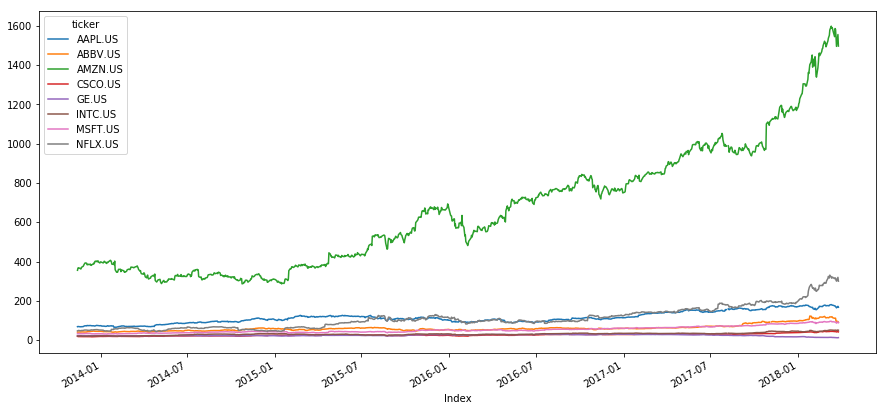

In [53]:
# plot the downloaded stock data - AdjClose prices
df_downloaded_all_tickers.pivot(columns='ticker', values='AdjClose').plot(figsize=(15,7))
plt.show()

## resume in ML model notebook(s)